In [14]:
%run common.ipynb

In [3]:
"""
Multi-Objective Knapsack Problem Solver using IBMOLS
"""
import numpy as np
import random
import math
import time
from typing import List, Tuple, Optional

class MOKPSolver:
    def __init__(self):
        # Constants
        self.DIMENSION = 2
        self.NBITEMS = 250
        self.FREQUANCY = 200
        self.L = 5
        self.LARGE = 1e50
        self.M_PI = math.pi
        
        # Problem data
        self.capacities = np.zeros(self.DIMENSION)
        self.weights = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        self.profits = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        
        # Algorithm parameters
        self.nf = self.DIMENSION
        self.ni = self.NBITEMS
        self.cardP = 0
        self.nombr = 0
        self.paretoIni = 28000
        self.perturbation_rate = 0.05
        self.smallValue = 0.0000001
        self.kappa = 0.05
        self.alpha = 10  # population size
        
        # Weight management
        self.OBJ_Weights = np.zeros((self.DIMENSION, 10000))
        self.nombreLIGNE = 0
        self.nextLn = 0
        self.inv = 0
        self.vector_weight = np.zeros(self.DIMENSION)
        self.max_bound = 0.0
        
        # Populations
        self.archive: Optional[Population] = None
        self.P: Optional[Population] = None
        self.solutions: Optional[Population] = None
        
        # Random seed
        self.iseed = 0

    def seed(self, seed_value: int):
        """Set random seed"""
        self.iseed = seed_value
        random.seed(seed_value)
        np.random.seed(seed_value)

    def load_MOKP(self, filename: str):
        """Load MOKP instance from file"""
        try:
            with open(filename, 'r') as f:
                line = f.readline().strip().split()
                self.nf, self.ni = int(line[0]), int(line[1])
                print(f"nf: {self.nf}, ni: {self.ni}")
                
                for f_idx in range(self.nf):
                    # Read capacity
                    capacity_line = f.readline().strip()
                    self.capacities[f_idx] = float(capacity_line)
                    
                    # Read weights and profits for each item
                    for i in range(self.ni):
                        f.readline()  # skip item name
                        weight_line = f.readline().strip()
                        profit_line = f.readline().strip()
                        
                        self.weights[f_idx][i] = int(weight_line)
                        self.profits[f_idx][i] = int(profit_line)
                        
        except FileNotFoundError:
            print(f"Error: File {filename} not found")
            return False
        return True

    def read_weights_file(self, filename: str):
        """Read weight vectors from file"""
        try:
            with open(filename, 'r') as f:
                lines = f.readlines()
                
            if self.nf == 2:
                self.nombreLIGNE = self.FREQUANCY // 4
            elif self.nf == 3:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            elif self.nf == 4:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            
            print(f"nombre ligne: {self.nombreLIGNE}")
            
            for i, line in enumerate(lines[:self.nombreLIGNE + 1]):
                weights = line.strip().split()
                for j in range(self.nf):
                    if j < len(weights):
                        self.OBJ_Weights[j][i] = float(weights[j])
                        
        except FileNotFoundError:
            print(f"Error: Weights file {filename} not found")
            return False
        return True

    def create_individual(self) -> Individual:
        """Create a new individual"""
        return Individual(self.nf, self.ni)

    def create_population(self, maxsize: int) -> Population:
        """Create a new population"""
        return Population(maxsize, self.nf)

    def copy_individual(self, ind: Individual) -> Individual:
        """Create a copy of an individual"""
        new_ind = self.create_individual()
        new_ind.nombr_nonpris = ind.nombr_nonpris
        new_ind.nombr = ind.nombr
        new_ind.rank = ind.rank
        new_ind.fitnessbest = ind.fitnessbest
        new_ind.fitness = ind.fitness
        new_ind.explored = ind.explored
        
        new_ind.f = ind.f.copy()
        new_ind.v = ind.v.copy()
        new_ind.capa = ind.capa.copy()
        new_ind.d = ind.d.copy()
        new_ind.Items = ind.Items.copy()
        
        return new_ind

    def dominates(self, a: Individual, b: Individual) -> bool:
        """Check if individual a dominates individual b"""
        a_is_worse = False
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_worse = True
                break
            equal = equal and (a.f[i] == b.f[i])
        
        return not equal and not a_is_worse

    def non_dominated(self, a: Individual, b: Individual) -> int:
        """Check domination relationship: -1 dominated, 0 equal, 1 non-dominated"""
        a_is_good = -1
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_good = 1
            equal = equal and (a.f[i] == b.f[i])
        
        if equal:
            return 0
        return a_is_good

    def irand(self, range_val: int) -> int:
        """Generate random integer"""
        return random.randint(0, range_val - 1)

    def random_init_individual(self, x: Individual):
        """Random initialization of an individual"""
        # Initialize permutation
        for j in range(self.ni):
            x.d[j] = j
            
        # Shuffle
        for j in range(self.ni):
            r = self.irand(self.ni)
            x.d[j], x.d[r] = x.d[r], x.d[j]

    def evaluate(self, x: Individual):
        """Evaluate an individual"""
        x.nombr = 0
        x.nombr_nonpris = 0
        
        # Reset objectives and capacities
        x.capa.fill(0)
        x.f.fill(0)
        x.Items.fill(0)
        
        for j in range(self.ni):
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][x.d[j]] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                # Add item
                for k in range(self.nf):
                    x.capa[k] += self.weights[k][x.d[j]]
                    x.f[k] += self.profits[k][x.d[j]]
                
                x.Items[x.d[j]] = 1
                x.nombr += 1
            else:
                x.Items[x.d[j]] = 0
                x.nombr_nonpris += 1

    def perturbation(self, x: Individual):
        """Apply perturbation to an individual"""
        bruit_rate = int(round(self.perturbation_rate * x.nombr))
        
        # Remove some items
        for j in range(bruit_rate):
            # Find a taken item to remove
            attempts = 0
            while attempts < 1000:  # Prevent infinite loop
                objet = self.irand(self.NBITEMS)
                if x.Items[objet] == 1:
                    break
                attempts += 1
            
            if attempts < 1000 and x.Items[objet] == 1:
                x.Items[objet] = 0
                x.nombr -= 1
                x.nombr_nonpris += 1
                
                for k in range(self.nf):
                    x.f[k] -= self.profits[k][objet]
                    x.capa[k] -= self.weights[k][objet]
        
        # Try to add items
        for j in range(x.nombr_nonpris):
            # Find an untaken item
            attempts = 0
            while attempts < 1000:
                objet1 = self.irand(self.NBITEMS)
                if x.Items[objet1] == 0:
                    break
                attempts += 1
            
            if attempts >= 1000:
                continue
                
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][objet1] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                x.Items[objet1] = 1
                x.nombr += 1
                x.nombr_nonpris -= 1
                
                for t in range(self.nf):
                    x.f[t] += self.profits[t][objet1]
                    x.capa[t] += self.weights[t][objet1]

    def dynamic_weight_allpop(self):
        """Dynamic weight selection"""
        for i in range(self.DIMENSION):
            self.vector_weight[i] = self.OBJ_Weights[i][self.nextLn]
        
        if self.nextLn == self.nombreLIGNE:
            self.nextLn = 0
        else:
            self.nextLn += 1

    def choose_weight(self):
        """Choose weight vector"""
        self.dynamic_weight_allpop()

    def random_init_pop(self, SP: Population, size: int):
        """Random initialization of population"""
        SP.size = size
        for i in range(SP.size):
            SP.ind_array[i] = self.create_individual()
            self.random_init_individual(SP.ind_array[i])
            self.evaluate(SP.ind_array[i])

    def init_pop(self, SP: Population, size: int):
        """Initialize population"""
        SP.size = size
        self.random_init_pop(SP, size)
        
        # Set explored to 0
        for i in range(SP.size):
            SP.ind_array[i].explored = 0

    def P_init_pop(self, SP: Population, Sarchive: Population, alpha: int):
        """Initialize population from archive"""
        SP.size = alpha
        t = max(alpha, Sarchive.size)
        shuffle = list(range(t))
        random.shuffle(shuffle)
        
        if Sarchive.size > alpha:
            # Pareto set sufficient
            print(f"size P {Sarchive.size}")
            for i in range(alpha):
                SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
        else:
            # Insert some random individuals
            for i in range(alpha):
                if shuffle[i] < Sarchive.size:
                    SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
                else:
                    SP.ind_array[i] = self.create_individual()
                    self.random_init_individual(SP.ind_array[i])
                    self.evaluate(SP.ind_array[i])

    def extractPtoArchive(self, P: Population, archive: Population) -> int:
        """Extract Pareto solutions to archive"""
        convergence_rate = 0
        t = archive.size + P.size
        
        # Create combined population
        archiveAndP = self.create_population(t)
        
        # Copy archive solutions
        for i in range(archive.size):
            archiveAndP.ind_array[i] = archive.ind_array[i]
        
        # Copy P solutions
        for i in range(P.size):
            archiveAndP.ind_array[i + archive.size] = self.copy_individual(P.ind_array[i])
        
        archiveAndP.size = t
        archive.size = 0
        
        # Find non-dominated solutions
        for i in range(t):
            dominated = False
            for j in range(t):
                if i != j:
                    dom = self.non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                    if dom == -1 or (dom == 0 and i > j):
                        dominated = True
                        break
            
            if not dominated:
                archive.ind_array[archive.size] = self.copy_individual(archiveAndP.ind_array[i])
                archive.size += 1
                if i >= t - P.size:
                    convergence_rate += 1
        
        return convergence_rate

    def calcul_weight(self, SP: Population, size: int):
        """Calculate weighted objectives"""
        for i in range(SP.size):
            for j in range(self.nf):
                SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * self.vector_weight[j]

    def calcMaxbound(self, SP: Population, size: int):
        """Calculate maximum bound"""
        SP.size = size
        if SP.size == 0:
            return
            
        self.max_bound = SP.ind_array[0].v[0]
        for i in range(SP.size):
            for j in range(self.nf):
                if self.max_bound < SP.ind_array[i].v[j]:
                    self.max_bound = SP.ind_array[i].v[j]

    def calcAddEpsIndicator(self, p_ind_a: Individual, p_ind_b: Individual) -> float:
        """Calculate additive epsilon indicator"""
        if self.max_bound == 0:
            return 0.0
            
        eps = (p_ind_a.v[0] / self.max_bound) - (p_ind_b.v[0] / self.max_bound)
        
        for i in range(1, self.nf):
            temp_eps = (p_ind_a.v[i] / self.max_bound) - (p_ind_b.v[i] / self.max_bound)
            if temp_eps > eps:
                eps = temp_eps
        
        return eps

    def init_fitness(self, x: Individual):
        """Initialize fitness"""
        x.fitness = 0.0

    def update_fitness(self, x: Individual, I: float):
        """Update fitness"""
        x.fitness -= math.exp(-I / self.kappa)

    def update_fitness_return(self, f: float, I: float) -> float:
        """Update fitness and return value"""
        return f - math.exp(-I / self.kappa)

    def delete_fitness(self, x: Individual, I: float) -> int:
        """Delete fitness contribution"""
        x.fitness += math.exp(-I / self.kappa)
        return 0

    def compute_ind_fitness(self, x: Individual, SP: Population):
        """Compute fitness of individual according to population"""
        self.init_fitness(x)
        for j in range(SP.size):
            if SP.ind_array[j] != x:
                I = self.calcAddEpsIndicator(SP.ind_array[j], x)
                self.update_fitness(x, I)

    def compute_all_fitness(self, SP: Population):
        """Compute fitness for all individuals"""
        for i in range(SP.size):
            self.compute_ind_fitness(SP.ind_array[i], SP)

    def compute_fitness_and_select(self, SP: Population, x: Individual, size: int) -> int:
        """Compute fitness and select individual for replacement"""
        SP.size = size
        worst = -1
        
        # Fitness for x
        x.fitness = 0
        self.compute_ind_fitness(x, SP)
        worst_fit = x.fitness
        
        # Update other fitness according to x
        for i in range(SP.size):
            I = self.calcAddEpsIndicator(x, SP.ind_array[i])
            fit_tmp = self.update_fitness_return(SP.ind_array[i].fitness, I)
            if fit_tmp > worst_fit:
                worst = i
                worst_fit = fit_tmp
        
        # Save x fitness
        fit_tmp = x.fitness
        
        # Check if we keep x
        if worst == -1:
            return -1
        else:
            # Update fitness
            for i in range(SP.size):
                I_worst = self.calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i])
                self.delete_fitness(SP.ind_array[i], I_worst)
                I_x = self.calcAddEpsIndicator(x, SP.ind_array[i])
                self.update_fitness(SP.ind_array[i], I_x)
            
            I_worst_x = self.calcAddEpsIndicator(SP.ind_array[worst], x)
            self.delete_fitness(x, I_worst_x)
            
            # Replace worst
            SP.ind_array[worst] = self.copy_individual(x)
            
            if fit_tmp - worst_fit > self.smallValue:
                return worst
            else:
                return -1

    def Indicator_local_search1(self, SP: Population, Sarchive: Population, size: int):
        """Indicator-based local search"""
        SP.size = size
        self.extractPtoArchive(SP, Sarchive)
        
        convergence = 0
        while True:
            convergence = 0
            
            for i in range(SP.size):
                if not SP.ind_array[i].explored:
                    x = self.copy_individual(SP.ind_array[i])
                    
                    for j in range(x.nombr):
                        remplace = [0] * self.L
                        
                        # Find item to remove
                        attempts = 0
                        while attempts < 1000:
                            mino = self.irand(self.NBITEMS)
                            if x.Items[mino] == 1:
                                break
                            attempts += 1
                        
                        if attempts >= 1000:
                            continue
                        
                        # Remove item
                        x.Items[mino] = 0
                        x.nombr -= 1
                        x.nombr_nonpris += 1
                        
                        for r in range(self.nf):
                            x.capa[r] -= self.weights[r][mino]
                            x.f[r] -= self.profits[r][mino]
                        
                        # Add some items
                        IM = 0
                        taille = 0
                        
                        while IM < self.L:
                            # Find item to add
                            attempts = 0
                            while attempts < 1000:
                                maxp = self.irand(self.NBITEMS)
                                if x.Items[maxp] == 0:
                                    break
                                attempts += 1
                            
                            if attempts >= 1000:
                                IM += 1
                                continue
                            
                            if maxp != mino:
                                # Check capacity constraint
                                consistant = True
                                for r in range(self.nf):
                                    if x.capa[r] + self.weights[r][maxp] > self.capacities[r]:
                                        consistant = False
                                        break
                                
                                if consistant:
                                    # Check if not already in remplace
                                    feasible = True
                                    for r in range(taille):
                                        if maxp == remplace[r]:
                                            feasible = False
                                            break
                                    
                                    if feasible:
                                        remplace[taille] = maxp
                                        taille += 1
                                        
                                        x.Items[maxp] = 1
                                        x.nombr_nonpris -= 1
                                        x.nombr += 1
                                        
                                        for r in range(self.nf):
                                            x.capa[r] += self.weights[r][maxp]
                                            x.f[r] += self.profits[r][maxp]
                            
                            IM += 1
                        
                        # Calculate weighted objectives
                        for tv in range(self.nf):
                            x.v[tv] = x.f[tv] * self.vector_weight[tv]
                        
                        self.calcMaxbound(SP, SP.size)
                        sol = self.compute_fitness_and_select(SP, x, SP.size)
                        
                        if sol != -1:
                            j = x.nombr + 1
                            if sol > i:
                                # Swap to avoid immediate exploration
                                SP.ind_array[i+1], SP.ind_array[sol] = SP.ind_array[sol], SP.ind_array[i+1]
                                i += 1
                        else:
                            # Restore original item
                            x.Items[mino] = 1
                            x.nombr_nonpris -= 1
                            x.nombr += 1
                            
                            for r in range(self.nf):
                                x.capa[r] += self.weights[r][mino]
                                x.f[r] += self.profits[r][mino]
                            
                            # Remove added items
                            if taille >= 1:
                                for r in range(taille):
                                    x.Items[remplace[r]] = 0
                                    x.nombr -= 1
                                    x.nombr_nonpris += 1
                                    
                                    for t in range(self.nf):
                                        x.capa[t] -= self.weights[t][remplace[r]]
                                        x.f[t] -= self.profits[t][remplace[r]]
                                        x.v[t] = x.f[t] * self.vector_weight[t]
                    
                    tmp_pris = x.nombr
                    if j == tmp_pris:
                        SP.ind_array[i].explored = 1
            
            convergence = self.extractPtoArchive(SP, Sarchive)
            if convergence == 0:
                break

    def run_algorithm(self, instance_file: str, weights_file: str, output_file: str, runs: int = 10):
        """Run the complete algorithm"""
        # Load problem instance
        if not self.load_MOKP(instance_file):
            return False
        
        # Load weights
        if not self.read_weights_file(weights_file):
            return False
        
        results = []
        
        for k in range(1, runs + 1):
            print(f"\nRun {k}")
            
            # Reset parameters
            self.nombreLIGNE = self.FREQUANCY // 4 if self.nf == 2 else self.nombreLIGNE
            self.nextLn = 0
            self.inv = 0
            
            # Set seed
            self.seed(k)
            
            # Initialize main population
            self.P = self.create_population(self.paretoIni)
            
            init_time = 0.0
            NBL = 100
            it = 0
            
            while it < NBL:
                # Create working populations
                self.solutions = self.create_population(self.alpha)
                self.archive = self.create_population(self.paretoIni)
                
                # Choose weight
                self.choose_weight()
                
                # Initialize population
                self.P_init_pop(self.solutions, self.P, self.alpha)
                self.extractPtoArchive(self.solutions, self.P)
                
                # Calculate weights and fitness
                self.calcul_weight(self.solutions, self.alpha)
                self.calcMaxbound(self.solutions, self.alpha)
                self.compute_all_fitness(self.solutions)
                
                # Run local search
                start_time = time.time()
                self.Indicator_local_search1(self.solutions, self.archive, self.alpha)
                self.extractPtoArchive(self.archive, self.P)
                duration = time.time() - start_time
                
                init_time += duration
                it += 1
                print(f"Iteration {it}, Duration: {duration:.3f}s")
            
            # Collect results from this run
            run_results = []
            for i in range(self.P.size):
                if self.P.ind_array[i] is not None:
                    objectives = [self.P.ind_array[i].f[j] for j in range(self.nf)]
                    run_results.append(objectives)
            
            results.extend(run_results)
            print(f"Run {k} completed, found {len(run_results)} solutions")
        
        # Save results
        with open(output_file, 'w') as f:
            for solution in results:
                f.write(' '.join(f"{obj:.6f}" for obj in solution) + '\n')
        
        print(f"\nTotal solutions found: {len(results)}")
        print(f"Results saved to {output_file}")
        
        return True

def main():
    """Main function"""
    solver = MOKPSolver()
    
    # Run the algorithm
    success = solver.run_algorithm(
        instance_file="250.2.txt",
        weights_file="Weights_2obj_FQ200.txt", 
        output_file="2502_Results.txt",
        runs=10
    )
    
    if success:
        print("Algorithm completed successfully!")
    else:
        print("Algorithm failed!")

if __name__ == "__main__":
    main()

nf: 2, ni: 250
nombre ligne: 50

Run 1
Iteration 1, Duration: 2.563s
size P 11
Iteration 2, Duration: 0.213s
Iteration 3, Duration: 1.514s
size P 12
Iteration 4, Duration: 0.171s
size P 12
Iteration 5, Duration: 0.173s
size P 12
Iteration 6, Duration: 0.282s
size P 13
Iteration 7, Duration: 0.613s
size P 12
Iteration 8, Duration: 0.202s
size P 13
Iteration 9, Duration: 0.205s
size P 18
Iteration 10, Duration: 1.043s
size P 21
Iteration 11, Duration: 1.158s
size P 26
Iteration 12, Duration: 0.216s
size P 26
Iteration 13, Duration: 0.769s
size P 26
Iteration 14, Duration: 0.674s
size P 29
Iteration 15, Duration: 0.972s
size P 41
Iteration 16, Duration: 0.542s
size P 45
Iteration 17, Duration: 0.864s
size P 51
Iteration 18, Duration: 0.854s
size P 56
Iteration 19, Duration: 1.638s
size P 58
Iteration 20, Duration: 0.145s
size P 58
Iteration 21, Duration: 1.407s
size P 69
Iteration 22, Duration: 0.877s
size P 77
Iteration 23, Duration: 1.468s
size P 89
Iteration 24, Duration: 1.507s
size P

Total points: 1732
Pareto-optimal points: 248


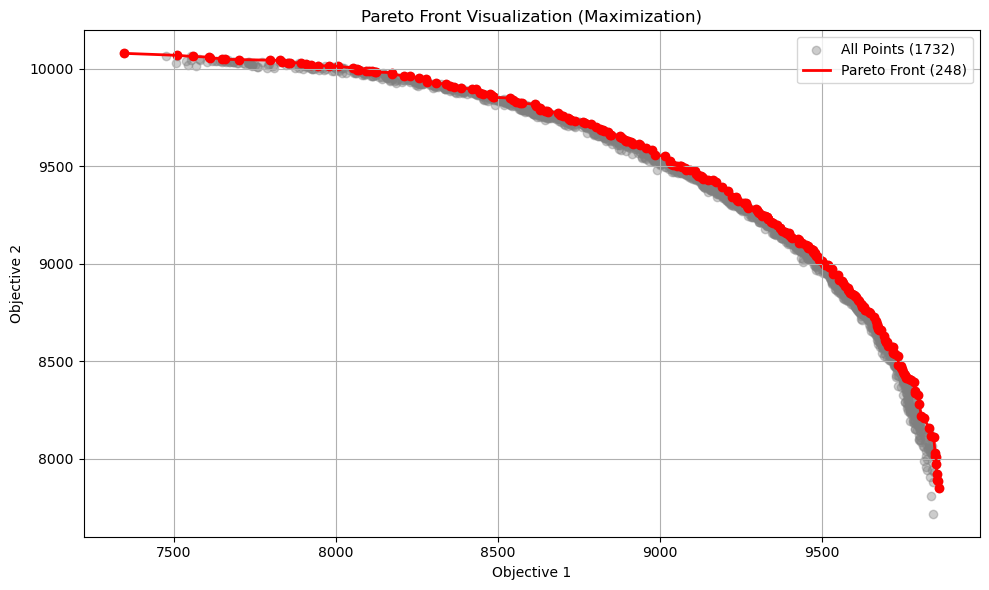

In [7]:
import matplotlib.pyplot as plt

def load_points(filename):
    points = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    x, y = map(float, parts)
                    points.append((x, y))
                except ValueError:
                    continue
    return points

def is_dominated(p1, p2):
    # For maximization
    return all(x1 <= x2 for x1, x2 in zip(p1, p2)) and any(x1 < x2 for x1, x2 in zip(p1, p2))

def get_pareto_front(points):
    pareto = []
    for p in points:
        if not any(is_dominated(p, other) for other in points if other != p):
            pareto.append(p)
    return pareto

def main():
    points = load_points("2502_Results.txt")
    pareto_front = get_pareto_front(points)
    pareto_front.sort()

    print(f"Total points: {len(points)}")
    print(f"Pareto-optimal points: {len(pareto_front)}")

    x_all, y_all = zip(*points)
    x_pareto, y_pareto = zip(*pareto_front)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_all, y_all, color='gray', alpha=0.4, label=f'All Points ({len(points)})')
    plt.plot(x_pareto, y_pareto, color='red', linewidth=2, label=f'Pareto Front ({len(pareto_front)})')
    plt.scatter(x_pareto, y_pareto, color='red')

    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.title("Pareto Front Visualization (Maximization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [15]:
"""
Multi-Objective Knapsack Problem Solver using IBMOLS
"""
import numpy as np
import random
import math
import time
from typing import List, Tuple, Optional

class MOKPSolver:
    def __init__(self):
        # Constants
        self.DIMENSION = 2
        self.NBITEMS = 500
        self.FREQUANCY = 200
        self.L = 5
        self.LARGE = 1e50
        self.M_PI = math.pi
        
        # Problem data
        self.capacities = np.zeros(self.DIMENSION)
        self.weights = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        self.profits = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        
        # Algorithm parameters
        self.nf = self.DIMENSION
        self.ni = self.NBITEMS
        self.cardP = 0
        self.nombr = 0
        self.paretoIni = 28000
        self.perturbation_rate = 0.05
        self.smallValue = 0.0000001
        self.kappa = 0.05
        self.alpha = 10  # population size
        
        # Weight management
        self.OBJ_Weights = np.zeros((self.DIMENSION, 10000))
        self.nombreLIGNE = 0
        self.nextLn = 0
        self.inv = 0
        self.vector_weight = np.zeros(self.DIMENSION)
        self.max_bound = 0.0
        
        # Populations
        self.archive: Optional[Population] = None
        self.P: Optional[Population] = None
        self.solutions: Optional[Population] = None
        
        # Random seed
        self.iseed = 0

    def seed(self, seed_value: int):
        """Set random seed"""
        self.iseed = seed_value
        random.seed(seed_value)
        np.random.seed(seed_value)

    def load_MOKP(self, filename: str):
        """Load MOKP instance from file"""
        try:
            with open(filename, 'r') as f:
                line = f.readline().strip().split()
                self.nf, self.ni = int(line[0]), int(line[1])
                print(f"nf: {self.nf}, ni: {self.ni}")
                
                for f_idx in range(self.nf):
                    # Read capacity
                    capacity_line = f.readline().strip()
                    self.capacities[f_idx] = float(capacity_line)
                    
                    # Read weights and profits for each item
                    for i in range(self.ni):
                        f.readline()  # skip item name
                        weight_line = f.readline().strip()
                        profit_line = f.readline().strip()
                        
                        self.weights[f_idx][i] = int(weight_line)
                        self.profits[f_idx][i] = int(profit_line)
                        
        except FileNotFoundError:
            print(f"Error: File {filename} not found")
            return False
        return True

    def read_weights_file(self, filename: str):
        """Read weight vectors from file"""
        try:
            with open(filename, 'r') as f:
                lines = f.readlines()
                
            if self.nf == 2:
                self.nombreLIGNE = self.FREQUANCY // 4
            elif self.nf == 3:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            elif self.nf == 4:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            
            print(f"nombre ligne: {self.nombreLIGNE}")
            
            for i, line in enumerate(lines[:self.nombreLIGNE + 1]):
                weights = line.strip().split()
                for j in range(self.nf):
                    if j < len(weights):
                        self.OBJ_Weights[j][i] = float(weights[j])
                        
        except FileNotFoundError:
            print(f"Error: Weights file {filename} not found")
            return False
        return True

    def create_individual(self) -> Individual:
        """Create a new individual"""
        return Individual(self.nf, self.ni)

    def create_population(self, maxsize: int) -> Population:
        """Create a new population"""
        return Population(maxsize, self.nf)

    def copy_individual(self, ind: Individual) -> Individual:
        """Create a copy of an individual"""
        new_ind = self.create_individual()
        new_ind.nombr_nonpris = ind.nombr_nonpris
        new_ind.nombr = ind.nombr
        new_ind.rank = ind.rank
        new_ind.fitnessbest = ind.fitnessbest
        new_ind.fitness = ind.fitness
        new_ind.explored = ind.explored
        
        new_ind.f = ind.f.copy()
        new_ind.v = ind.v.copy()
        new_ind.capa = ind.capa.copy()
        new_ind.d = ind.d.copy()
        new_ind.Items = ind.Items.copy()
        
        return new_ind

    def dominates(self, a: Individual, b: Individual) -> bool:
        """Check if individual a dominates individual b"""
        a_is_worse = False
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_worse = True
                break
            equal = equal and (a.f[i] == b.f[i])
        
        return not equal and not a_is_worse

    def non_dominated(self, a: Individual, b: Individual) -> int:
        """Check domination relationship: -1 dominated, 0 equal, 1 non-dominated"""
        a_is_good = -1
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_good = 1
            equal = equal and (a.f[i] == b.f[i])
        
        if equal:
            return 0
        return a_is_good

    def irand(self, range_val: int) -> int:
        """Generate random integer"""
        return random.randint(0, range_val - 1)

    def random_init_individual(self, x: Individual):
        """Random initialization of an individual"""
        # Initialize permutation
        for j in range(self.ni):
            x.d[j] = j
            
        # Shuffle
        for j in range(self.ni):
            r = self.irand(self.ni)
            x.d[j], x.d[r] = x.d[r], x.d[j]

    def evaluate(self, x: Individual):
        """Evaluate an individual"""
        x.nombr = 0
        x.nombr_nonpris = 0
        
        # Reset objectives and capacities
        x.capa.fill(0)
        x.f.fill(0)
        x.Items.fill(0)
        
        for j in range(self.ni):
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][x.d[j]] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                # Add item
                for k in range(self.nf):
                    x.capa[k] += self.weights[k][x.d[j]]
                    x.f[k] += self.profits[k][x.d[j]]
                
                x.Items[x.d[j]] = 1
                x.nombr += 1
            else:
                x.Items[x.d[j]] = 0
                x.nombr_nonpris += 1

    def perturbation(self, x: Individual):
        """Apply perturbation to an individual"""
        bruit_rate = int(round(self.perturbation_rate * x.nombr))
        
        # Remove some items
        for j in range(bruit_rate):
            # Find a taken item to remove
            attempts = 0
            while attempts < 1000:  # Prevent infinite loop
                objet = self.irand(self.NBITEMS)
                if x.Items[objet] == 1:
                    break
                attempts += 1
            
            if attempts < 1000 and x.Items[objet] == 1:
                x.Items[objet] = 0
                x.nombr -= 1
                x.nombr_nonpris += 1
                
                for k in range(self.nf):
                    x.f[k] -= self.profits[k][objet]
                    x.capa[k] -= self.weights[k][objet]
        
        # Try to add items
        for j in range(x.nombr_nonpris):
            # Find an untaken item
            attempts = 0
            while attempts < 1000:
                objet1 = self.irand(self.NBITEMS)
                if x.Items[objet1] == 0:
                    break
                attempts += 1
            
            if attempts >= 1000:
                continue
                
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][objet1] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                x.Items[objet1] = 1
                x.nombr += 1
                x.nombr_nonpris -= 1
                
                for t in range(self.nf):
                    x.f[t] += self.profits[t][objet1]
                    x.capa[t] += self.weights[t][objet1]

    def dynamic_weight_allpop(self):
        """Dynamic weight selection"""
        for i in range(self.DIMENSION):
            self.vector_weight[i] = self.OBJ_Weights[i][self.nextLn]
        
        if self.nextLn == self.nombreLIGNE:
            self.nextLn = 0
        else:
            self.nextLn += 1

    def choose_weight(self):
        """Choose weight vector"""
        self.dynamic_weight_allpop()

    def random_init_pop(self, SP: Population, size: int):
        """Random initialization of population"""
        SP.size = size
        for i in range(SP.size):
            SP.ind_array[i] = self.create_individual()
            self.random_init_individual(SP.ind_array[i])
            self.evaluate(SP.ind_array[i])

    def init_pop(self, SP: Population, size: int):
        """Initialize population"""
        SP.size = size
        self.random_init_pop(SP, size)
        
        # Set explored to 0
        for i in range(SP.size):
            SP.ind_array[i].explored = 0

    def P_init_pop(self, SP: Population, Sarchive: Population, alpha: int):
        """Initialize population from archive"""
        SP.size = alpha
        t = max(alpha, Sarchive.size)
        shuffle = list(range(t))
        random.shuffle(shuffle)
        
        if Sarchive.size > alpha:
            # Pareto set sufficient
            print(f"size P {Sarchive.size}")
            for i in range(alpha):
                SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
        else:
            # Insert some random individuals
            for i in range(alpha):
                if shuffle[i] < Sarchive.size:
                    SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
                else:
                    SP.ind_array[i] = self.create_individual()
                    self.random_init_individual(SP.ind_array[i])
                    self.evaluate(SP.ind_array[i])

    def extractPtoArchive(self, P: Population, archive: Population) -> int:
        """Extract Pareto solutions to archive"""
        convergence_rate = 0
        t = archive.size + P.size
        
        # Create combined population
        archiveAndP = self.create_population(t)
        
        # Copy archive solutions
        for i in range(archive.size):
            archiveAndP.ind_array[i] = archive.ind_array[i]
        
        # Copy P solutions
        for i in range(P.size):
            archiveAndP.ind_array[i + archive.size] = self.copy_individual(P.ind_array[i])
        
        archiveAndP.size = t
        archive.size = 0
        
        # Find non-dominated solutions
        for i in range(t):
            dominated = False
            for j in range(t):
                if i != j:
                    dom = self.non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                    if dom == -1 or (dom == 0 and i > j):
                        dominated = True
                        break
            
            if not dominated:
                archive.ind_array[archive.size] = self.copy_individual(archiveAndP.ind_array[i])
                archive.size += 1
                if i >= t - P.size:
                    convergence_rate += 1
        
        return convergence_rate

    def calcul_weight(self, SP: Population, size: int):
        """Calculate weighted objectives"""
        for i in range(SP.size):
            for j in range(self.nf):
                SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * self.vector_weight[j]

    def calcMaxbound(self, SP: Population, size: int):
        """Calculate maximum bound"""
        SP.size = size
        if SP.size == 0:
            return
            
        self.max_bound = SP.ind_array[0].v[0]
        for i in range(SP.size):
            for j in range(self.nf):
                if self.max_bound < SP.ind_array[i].v[j]:
                    self.max_bound = SP.ind_array[i].v[j]

    def calcAddEpsIndicator(self, p_ind_a: Individual, p_ind_b: Individual) -> float:
        """Calculate additive epsilon indicator"""
        if self.max_bound == 0:
            return 0.0
            
        eps = (p_ind_a.v[0] / self.max_bound) - (p_ind_b.v[0] / self.max_bound)
        
        for i in range(1, self.nf):
            temp_eps = (p_ind_a.v[i] / self.max_bound) - (p_ind_b.v[i] / self.max_bound)
            if temp_eps > eps:
                eps = temp_eps
        
        return eps

    def init_fitness(self, x: Individual):
        """Initialize fitness"""
        x.fitness = 0.0

    def update_fitness(self, x: Individual, I: float):
        """Update fitness"""
        x.fitness -= math.exp(-I / self.kappa)

    def update_fitness_return(self, f: float, I: float) -> float:
        """Update fitness and return value"""
        return f - math.exp(-I / self.kappa)

    def delete_fitness(self, x: Individual, I: float) -> int:
        """Delete fitness contribution"""
        x.fitness += math.exp(-I / self.kappa)
        return 0

    def compute_ind_fitness(self, x: Individual, SP: Population):
        """Compute fitness of individual according to population"""
        self.init_fitness(x)
        for j in range(SP.size):
            if SP.ind_array[j] != x:
                I = self.calcAddEpsIndicator(SP.ind_array[j], x)
                self.update_fitness(x, I)

    def compute_all_fitness(self, SP: Population):
        """Compute fitness for all individuals"""
        for i in range(SP.size):
            self.compute_ind_fitness(SP.ind_array[i], SP)

    def compute_fitness_and_select(self, SP: Population, x: Individual, size: int) -> int:
        """Compute fitness and select individual for replacement"""
        SP.size = size
        worst = -1
        
        # Fitness for x
        x.fitness = 0
        self.compute_ind_fitness(x, SP)
        worst_fit = x.fitness
        
        # Update other fitness according to x
        for i in range(SP.size):
            I = self.calcAddEpsIndicator(x, SP.ind_array[i])
            fit_tmp = self.update_fitness_return(SP.ind_array[i].fitness, I)
            if fit_tmp > worst_fit:
                worst = i
                worst_fit = fit_tmp
        
        # Save x fitness
        fit_tmp = x.fitness
        
        # Check if we keep x
        if worst == -1:
            return -1
        else:
            # Update fitness
            for i in range(SP.size):
                I_worst = self.calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i])
                self.delete_fitness(SP.ind_array[i], I_worst)
                I_x = self.calcAddEpsIndicator(x, SP.ind_array[i])
                self.update_fitness(SP.ind_array[i], I_x)
            
            I_worst_x = self.calcAddEpsIndicator(SP.ind_array[worst], x)
            self.delete_fitness(x, I_worst_x)
            
            # Replace worst
            SP.ind_array[worst] = self.copy_individual(x)
            
            if fit_tmp - worst_fit > self.smallValue:
                return worst
            else:
                return -1

    def Indicator_local_search1(self, SP: Population, Sarchive: Population, size: int):
        """Indicator-based local search"""
        SP.size = size
        self.extractPtoArchive(SP, Sarchive)
        
        convergence = 0
        while True:
            convergence = 0
            
            for i in range(SP.size):
                if not SP.ind_array[i].explored:
                    x = self.copy_individual(SP.ind_array[i])
                    
                    for j in range(x.nombr):
                        remplace = [0] * self.L
                        
                        # Find item to remove
                        attempts = 0
                        while attempts < 1000:
                            mino = self.irand(self.NBITEMS)
                            if x.Items[mino] == 1:
                                break
                            attempts += 1
                        
                        if attempts >= 1000:
                            continue
                        
                        # Remove item
                        x.Items[mino] = 0
                        x.nombr -= 1
                        x.nombr_nonpris += 1
                        
                        for r in range(self.nf):
                            x.capa[r] -= self.weights[r][mino]
                            x.f[r] -= self.profits[r][mino]
                        
                        # Add some items
                        IM = 0
                        taille = 0
                        
                        while IM < self.L:
                            # Find item to add
                            attempts = 0
                            while attempts < 1000:
                                maxp = self.irand(self.NBITEMS)
                                if x.Items[maxp] == 0:
                                    break
                                attempts += 1
                            
                            if attempts >= 1000:
                                IM += 1
                                continue
                            
                            if maxp != mino:
                                # Check capacity constraint
                                consistant = True
                                for r in range(self.nf):
                                    if x.capa[r] + self.weights[r][maxp] > self.capacities[r]:
                                        consistant = False
                                        break
                                
                                if consistant:
                                    # Check if not already in remplace
                                    feasible = True
                                    for r in range(taille):
                                        if maxp == remplace[r]:
                                            feasible = False
                                            break
                                    
                                    if feasible:
                                        remplace[taille] = maxp
                                        taille += 1
                                        
                                        x.Items[maxp] = 1
                                        x.nombr_nonpris -= 1
                                        x.nombr += 1
                                        
                                        for r in range(self.nf):
                                            x.capa[r] += self.weights[r][maxp]
                                            x.f[r] += self.profits[r][maxp]
                            
                            IM += 1
                        
                        # Calculate weighted objectives
                        for tv in range(self.nf):
                            x.v[tv] = x.f[tv] * self.vector_weight[tv]
                        
                        self.calcMaxbound(SP, SP.size)
                        sol = self.compute_fitness_and_select(SP, x, SP.size)
                        
                        if sol != -1:
                            j = x.nombr + 1
                            if sol > i:
                                # Swap to avoid immediate exploration
                                SP.ind_array[i+1], SP.ind_array[sol] = SP.ind_array[sol], SP.ind_array[i+1]
                                i += 1
                        else:
                            # Restore original item
                            x.Items[mino] = 1
                            x.nombr_nonpris -= 1
                            x.nombr += 1
                            
                            for r in range(self.nf):
                                x.capa[r] += self.weights[r][mino]
                                x.f[r] += self.profits[r][mino]
                            
                            # Remove added items
                            if taille >= 1:
                                for r in range(taille):
                                    x.Items[remplace[r]] = 0
                                    x.nombr -= 1
                                    x.nombr_nonpris += 1
                                    
                                    for t in range(self.nf):
                                        x.capa[t] -= self.weights[t][remplace[r]]
                                        x.f[t] -= self.profits[t][remplace[r]]
                                        x.v[t] = x.f[t] * self.vector_weight[t]
                    
                    tmp_pris = x.nombr
                    if j == tmp_pris:
                        SP.ind_array[i].explored = 1
            
            convergence = self.extractPtoArchive(SP, Sarchive)
            if convergence == 0:
                break

    def run_algorithm(self, instance_file: str, weights_file: str, output_file: str, runs: int = 10):
        """Run the complete algorithm"""
        # Load problem instance
        if not self.load_MOKP(instance_file):
            return False
        
        # Load weights
        if not self.read_weights_file(weights_file):
            return False
        
        results = []
        
        for k in range(1, runs + 1):
            print(f"\nRun {k}")
            
            # Reset parameters
            self.nombreLIGNE = self.FREQUANCY // 4 if self.nf == 2 else self.nombreLIGNE
            self.nextLn = 0
            self.inv = 0
            
            # Set seed
            self.seed(k)
            
            # Initialize main population
            self.P = self.create_population(self.paretoIni)
            
            init_time = 0.0
            NBL = 100
            it = 0
            
            while it < NBL:
                # Create working populations
                self.solutions = self.create_population(self.alpha)
                self.archive = self.create_population(self.paretoIni)
                
                # Choose weight
                self.choose_weight()
                
                # Initialize population
                self.P_init_pop(self.solutions, self.P, self.alpha)
                self.extractPtoArchive(self.solutions, self.P)
                
                # Calculate weights and fitness
                self.calcul_weight(self.solutions, self.alpha)
                self.calcMaxbound(self.solutions, self.alpha)
                self.compute_all_fitness(self.solutions)
                
                # Run local search
                start_time = time.time()
                self.Indicator_local_search1(self.solutions, self.archive, self.alpha)
                self.extractPtoArchive(self.archive, self.P)
                duration = time.time() - start_time
                
                init_time += duration
                it += 1
                print(f"Iteration {it}, Duration: {duration:.3f}s")
            
            # Collect results from this run
            run_results = []
            for i in range(self.P.size):
                if self.P.ind_array[i] is not None:
                    objectives = [self.P.ind_array[i].f[j] for j in range(self.nf)]
                    run_results.append(objectives)
            
            results.extend(run_results)
            print(f"Run {k} completed, found {len(run_results)} solutions")
        
        # Save results
        with open(output_file, 'w') as f:
            for solution in results:
                f.write(' '.join(f"{obj:.6f}" for obj in solution) + '\n')
        
        print(f"\nTotal solutions found: {len(results)}")
        print(f"Results saved to {output_file}")
        
        return True

def main():
    """Main function"""
    solver = MOKPSolver()
    
    # Run the algorithm
    success = solver.run_algorithm(
        instance_file="500.2.txt",
        weights_file="Weights_2obj_FQ200.txt", 
        output_file="500_Results.txt",
        runs=10
    )
    
    if success:
        print("Algorithm completed successfully!")
    else:
        print("Algorithm failed!")

if __name__ == "__main__":
    main()

nf: 2, ni: 500
nombre ligne: 50

Run 1
Iteration 1, Duration: 6.294s
Iteration 2, Duration: 0.202s
Iteration 3, Duration: 2.034s
Iteration 4, Duration: 1.513s
Iteration 5, Duration: 1.238s
Iteration 6, Duration: 0.410s
Iteration 7, Duration: 1.594s
Iteration 8, Duration: 1.389s
size P 11
Iteration 9, Duration: 1.494s
size P 20
Iteration 10, Duration: 3.439s
size P 25
Iteration 11, Duration: 0.620s
size P 28
Iteration 12, Duration: 1.474s
size P 34
Iteration 13, Duration: 1.073s
size P 35
Iteration 14, Duration: 1.322s
size P 42
Iteration 15, Duration: 0.885s
size P 46
Iteration 16, Duration: 5.454s
size P 89
Iteration 17, Duration: 0.899s
size P 90
Iteration 18, Duration: 0.847s
size P 90
Iteration 19, Duration: 3.071s
size P 100
Iteration 20, Duration: 3.450s
size P 123
Iteration 21, Duration: 2.926s
size P 132
Iteration 22, Duration: 3.082s
size P 149
Iteration 23, Duration: 3.165s
size P 149
Iteration 24, Duration: 1.697s
size P 148
Iteration 25, Duration: 4.527s
size P 172
Iteratio

Total points: 3034
Pareto-optimal points: 390


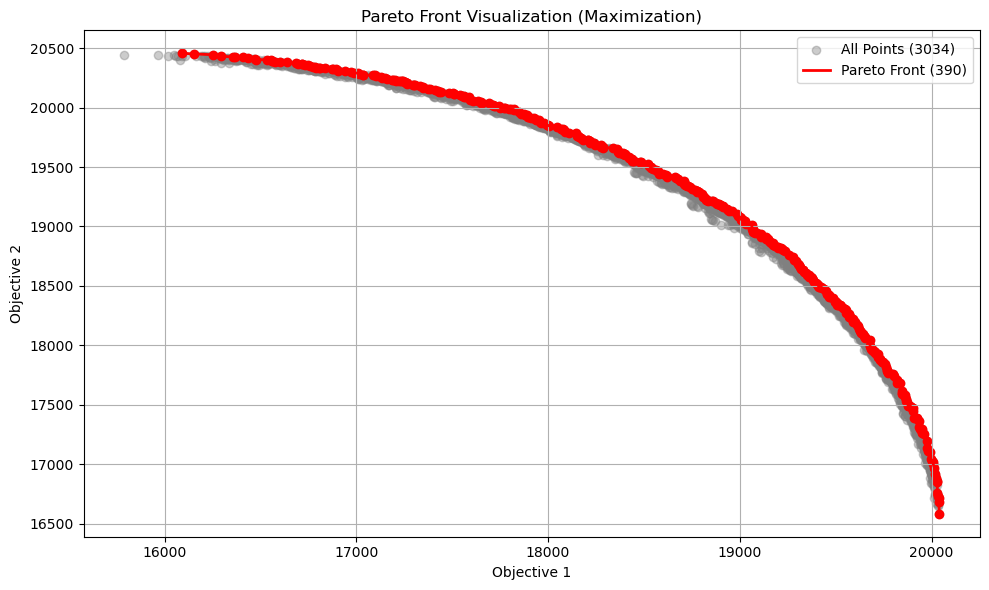

In [18]:
import matplotlib.pyplot as plt

def load_points(filename):
    points = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    x, y = map(float, parts)
                    points.append((x, y))
                except ValueError:
                    continue
    return points

def is_dominated(p1, p2):
    # For maximization
    return all(x1 <= x2 for x1, x2 in zip(p1, p2)) and any(x1 < x2 for x1, x2 in zip(p1, p2))

def get_pareto_front(points):
    pareto = []
    for p in points:
        if not any(is_dominated(p, other) for other in points if other != p):
            pareto.append(p)
    return pareto

def main():
    points = load_points("500_Results.txt")
    pareto_front = get_pareto_front(points)
    pareto_front.sort()

    print(f"Total points: {len(points)}")
    print(f"Pareto-optimal points: {len(pareto_front)}")

    x_all, y_all = zip(*points)
    x_pareto, y_pareto = zip(*pareto_front)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_all, y_all, color='gray', alpha=0.4, label=f'All Points ({len(points)})')
    plt.plot(x_pareto, y_pareto, color='red', linewidth=2, label=f'Pareto Front ({len(pareto_front)})')
    plt.scatter(x_pareto, y_pareto, color='red')

    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.title("Pareto Front Visualization (Maximization)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
###########################################################################################################################

In [ ]:
###########################################################################################################################

In [ ]:
###########################################################################################################################

In [ ]:
###########################################################################################################################

In [ ]:
###########################################################################################################################

In [1]:
###########################################################whOLE CODE COMPLETE################################################################

In [2]:
"""
Multi-Objective Knapsack Problem Solver using IBMOLS - Improved Version
"""
import numpy as np
import random
import math
import time
import os
from typing import List, Tuple, Optional

class Individual:
    """Individual solution representation"""
    def __init__(self, nf: int, ni: int):
        self.nf = nf
        self.ni = ni
        self.nombr = 0
        self.nombr_nonpris = 0
        self.rank = 0
        self.fitnessbest = 0.0
        self.fitness = 0.0
        self.explored = 0
        
        # Arrays
        self.f = np.zeros(nf)
        self.v = np.zeros(nf)
        self.capa = np.zeros(nf)
        self.d = np.zeros(ni, dtype=int)
        self.Items = np.zeros(ni, dtype=int)

class Population:
    """Population of individuals"""
    def __init__(self, maxsize: int, nf: int):
        self.maxsize = maxsize
        self.size = 0
        self.nf = nf
        self.ind_array = [None] * maxsize

class MOKPSolver:
    def __init__(self):
        # Problem parameters (will be set dynamically)
        self.DIMENSION = 2
        self.NBITEMS = 250
        self.FREQUANCY = 200
        
        # Algorithm constants
        self.L = 5
        self.LARGE = 1e50
        self.M_PI = math.pi
        
        # Problem data (will be resized based on input)
        self.capacities = None
        self.weights = None
        self.profits = None
        
        # Algorithm parameters
        self.nf = 2
        self.ni = 250
        self.cardP = 0
        self.nombr = 0
        self.paretoIni = 28000
        self.perturbation_rate = 0.05
        self.smallValue = 0.0000001
        self.kappa = 0.05
        self.alpha = 10  # population size
        
        # Weight management
        self.OBJ_Weights = None
        self.nombreLIGNE = 0
        self.nextLn = 0
        self.inv = 0
        self.vector_weight = None
        self.max_bound = 0.0
        
        # Populations
        self.archive: Optional[Population] = None
        self.P: Optional[Population] = None
        self.solutions: Optional[Population] = None
        
        # Random seed
        self.iseed = 0

    def parse_filename(self, filename: str) -> Tuple[int, int]:
        """Parse filename to extract number of items and objectives"""
        # Remove extension
        basename = os.path.splitext(filename)[0]
        
        # Expected format: "items.objectives" e.g., "250.2", "500.3"
        parts = basename.split('.')
        if len(parts) == 2:
            try:
                items = int(parts[0])
                objectives = int(parts[1])
                return items, objectives
            except ValueError:
                pass
        
        # Default fallback
        return 250, 2

    def get_weight_filename(self, objectives: int) -> str:
        """Get appropriate weight filename based on number of objectives"""
        weight_files = {
            2: "Weights_2obj_FQ200.txt",
            3: "Weights_3obj_FQ100.txt", 
            4: "Weights_4obj_FQ40.txt"
        }
        
        return weight_files.get(objectives, "Weights_2obj_FQ200.txt")

    def get_frequency(self, objectives: int) -> int:
        """Get frequency based on number of objectives"""
        frequencies = {
            2: 200,
            3: 100,
            4: 40
        }
        
        return frequencies.get(objectives, 200)

    def initialize_problem_size(self, items: int, objectives: int):
        """Initialize problem size and allocate arrays"""
        self.NBITEMS = items
        self.DIMENSION = objectives
        self.ni = items
        self.nf = objectives
        self.FREQUANCY = self.get_frequency(objectives)
        
        # Allocate arrays
        self.capacities = np.zeros(self.DIMENSION)
        self.weights = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        self.profits = np.zeros((self.DIMENSION, self.NBITEMS), dtype=int)
        
        # Weight management arrays
        self.OBJ_Weights = np.zeros((self.DIMENSION, 10000))
        self.vector_weight = np.zeros(self.DIMENSION)
        
        print(f"Initialized problem: {items} items, {objectives} objectives, frequency {self.FREQUANCY}")

    def seed(self, seed_value: int):
        """Set random seed"""
        self.iseed = seed_value
        random.seed(seed_value)
        np.random.seed(seed_value)

    def load_MOKP(self, filename: str):
        """Load MOKP instance from file"""
        try:
            # Parse filename to get problem dimensions
            items, objectives = self.parse_filename(filename)
            self.initialize_problem_size(items, objectives)
            
            with open(filename, 'r') as f:
                line = f.readline().strip().split()
                file_nf, file_ni = int(line[0]), int(line[1])
                
                # Verify parsed dimensions match file content
                if file_nf != self.nf or file_ni != self.ni:
                    print(f"Warning: Filename suggests {objectives}obj, {items}items but file contains {file_nf}obj, {file_ni}items")
                    # Use file dimensions
                    self.initialize_problem_size(file_ni, file_nf)
                
                print(f"Loading: {self.nf} objectives, {self.ni} items")
                
                for f_idx in range(self.nf):
                    # Read capacity
                    capacity_line = f.readline().strip()
                    self.capacities[f_idx] = float(capacity_line)
                    
                    # Read weights and profits for each item
                    for i in range(self.ni):
                        f.readline()  # skip item name
                        weight_line = f.readline().strip()
                        profit_line = f.readline().strip()
                        
                        self.weights[f_idx][i] = int(weight_line)
                        self.profits[f_idx][i] = int(profit_line)
                        
        except FileNotFoundError:
            print(f"Error: File {filename} not found")
            return False
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return False
        return True

    def read_weights_file(self, filename: str):
        """Read weight vectors from file"""
        try:
            with open(filename, 'r') as f:
                lines = f.readlines()
                
            # Calculate number of weight vectors based on dimensions
            if self.nf == 2:
                self.nombreLIGNE = self.FREQUANCY // 4
            elif self.nf == 3:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            elif self.nf == 4:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            else:
                self.nombreLIGNE = min(len(lines), 1000)  # Fallback
            
            print(f"Loading {self.nombreLIGNE} weight vectors from {filename}")
            
            for i, line in enumerate(lines[:self.nombreLIGNE + 1]):
                if i > self.nombreLIGNE:
                    break
                weights = line.strip().split()
                for j in range(self.nf):
                    if j < len(weights):
                        self.OBJ_Weights[j][i] = float(weights[j])
                        
        except FileNotFoundError:
            print(f"Error: Weights file {filename} not found")
            return False
        except Exception as e:
            print(f"Error loading weights from {filename}: {e}")
            return False
        return True

    def create_individual(self) -> Individual:
        """Create a new individual"""
        return Individual(self.nf, self.ni)

    def create_population(self, maxsize: int) -> Population:
        """Create a new population"""
        return Population(maxsize, self.nf)

    def copy_individual(self, ind: Individual) -> Individual:
        """Create a copy of an individual"""
        new_ind = self.create_individual()
        new_ind.nombr_nonpris = ind.nombr_nonpris
        new_ind.nombr = ind.nombr
        new_ind.rank = ind.rank
        new_ind.fitnessbest = ind.fitnessbest
        new_ind.fitness = ind.fitness
        new_ind.explored = ind.explored
        
        new_ind.f = ind.f.copy()
        new_ind.v = ind.v.copy()
        new_ind.capa = ind.capa.copy()
        new_ind.d = ind.d.copy()
        new_ind.Items = ind.Items.copy()
        
        return new_ind

    def dominates(self, a: Individual, b: Individual) -> bool:
        """Check if individual a dominates individual b"""
        a_is_worse = False
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_worse = True
                break
            equal = equal and (a.f[i] == b.f[i])
        
        return not equal and not a_is_worse

    def non_dominated(self, a: Individual, b: Individual) -> int:
        """Check domination relationship: -1 dominated, 0 equal, 1 non-dominated"""
        a_is_good = -1
        equal = True
        
        for i in range(self.nf):
            if a.f[i] > b.f[i]:
                a_is_good = 1
            equal = equal and (a.f[i] == b.f[i])
        
        if equal:
            return 0
        return a_is_good

    def irand(self, range_val: int) -> int:
        """Generate random integer"""
        return random.randint(0, range_val - 1)

    def random_init_individual(self, x: Individual):
        """Random initialization of an individual"""
        # Initialize permutation
        for j in range(self.ni):
            x.d[j] = j
            
        # Shuffle
        for j in range(self.ni):
            r = self.irand(self.ni)
            x.d[j], x.d[r] = x.d[r], x.d[j]

    def evaluate(self, x: Individual):
        """Evaluate an individual"""
        x.nombr = 0
        x.nombr_nonpris = 0
        
        # Reset objectives and capacities
        x.capa.fill(0)
        x.f.fill(0)
        x.Items.fill(0)
        
        for j in range(self.ni):
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][x.d[j]] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                # Add item
                for k in range(self.nf):
                    x.capa[k] += self.weights[k][x.d[j]]
                    x.f[k] += self.profits[k][x.d[j]]
                
                x.Items[x.d[j]] = 1
                x.nombr += 1
            else:
                x.Items[x.d[j]] = 0
                x.nombr_nonpris += 1

    def perturbation(self, x: Individual):
        """Apply perturbation to an individual"""
        bruit_rate = int(round(self.perturbation_rate * x.nombr))
        
        # Remove some items
        for j in range(bruit_rate):
            # Find a taken item to remove
            attempts = 0
            while attempts < 1000:  # Prevent infinite loop
                objet = self.irand(self.ni)
                if x.Items[objet] == 1:
                    break
                attempts += 1
            
            if attempts < 1000 and x.Items[objet] == 1:
                x.Items[objet] = 0
                x.nombr -= 1
                x.nombr_nonpris += 1
                
                for k in range(self.nf):
                    x.f[k] -= self.profits[k][objet]
                    x.capa[k] -= self.weights[k][objet]
        
        # Try to add items
        for j in range(x.nombr_nonpris):
            # Find an untaken item
            attempts = 0
            while attempts < 1000:
                objet1 = self.irand(self.ni)
                if x.Items[objet1] == 0:
                    break
                attempts += 1
            
            if attempts >= 1000:
                continue
                
            # Check feasibility
            feasible = True
            for l in range(self.nf):
                if x.capa[l] + self.weights[l][objet1] > self.capacities[l]:
                    feasible = False
                    break
            
            if feasible:
                x.Items[objet1] = 1
                x.nombr += 1
                x.nombr_nonpris -= 1
                
                for t in range(self.nf):
                    x.f[t] += self.profits[t][objet1]
                    x.capa[t] += self.weights[t][objet1]

    def dynamic_weight_allpop(self):
        """Dynamic weight selection"""
        for i in range(self.nf):
            self.vector_weight[i] = self.OBJ_Weights[i][self.nextLn]
        
        if self.nextLn == self.nombreLIGNE:
            self.nextLn = 0
        else:
            self.nextLn += 1

    def choose_weight(self):
        """Choose weight vector"""
        self.dynamic_weight_allpop()

    def random_init_pop(self, SP: Population, size: int):
        """Random initialization of population"""
        SP.size = size
        for i in range(SP.size):
            SP.ind_array[i] = self.create_individual()
            self.random_init_individual(SP.ind_array[i])
            self.evaluate(SP.ind_array[i])

    def init_pop(self, SP: Population, size: int):
        """Initialize population"""
        SP.size = size
        self.random_init_pop(SP, size)
        
        # Set explored to 0
        for i in range(SP.size):
            SP.ind_array[i].explored = 0

    def P_init_pop(self, SP: Population, Sarchive: Population, alpha: int):
        """Initialize population from archive"""
        SP.size = alpha
        t = max(alpha, Sarchive.size)
        shuffle = list(range(t))
        random.shuffle(shuffle)
        
        if Sarchive.size > alpha:
            # Pareto set sufficient
            print(f"size P {Sarchive.size}")
            for i in range(alpha):
                SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
        else:
            # Insert some random individuals
            for i in range(alpha):
                if shuffle[i] < Sarchive.size:
                    SP.ind_array[i] = self.copy_individual(Sarchive.ind_array[shuffle[i]])
                else:
                    SP.ind_array[i] = self.create_individual()
                    self.random_init_individual(SP.ind_array[i])
                    self.evaluate(SP.ind_array[i])

    def extractPtoArchive(self, P: Population, archive: Population) -> int:
        """Extract Pareto solutions to archive"""
        convergence_rate = 0
        t = archive.size + P.size
        
        # Create combined population
        archiveAndP = self.create_population(t)
        
        # Copy archive solutions
        for i in range(archive.size):
            archiveAndP.ind_array[i] = archive.ind_array[i]
        
        # Copy P solutions
        for i in range(P.size):
            archiveAndP.ind_array[i + archive.size] = self.copy_individual(P.ind_array[i])
        
        archiveAndP.size = t
        archive.size = 0
        
        # Find non-dominated solutions
        for i in range(t):
            dominated = False
            for j in range(t):
                if i != j:
                    dom = self.non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                    if dom == -1 or (dom == 0 and i > j):
                        dominated = True
                        break
            
            if not dominated:
                archive.ind_array[archive.size] = self.copy_individual(archiveAndP.ind_array[i])
                archive.size += 1
                if i >= t - P.size:
                    convergence_rate += 1
        
        return convergence_rate

    def calcul_weight(self, SP: Population, size: int):
        """Calculate weighted objectives"""
        for i in range(SP.size):
            for j in range(self.nf):
                SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * self.vector_weight[j]

    def calcMaxbound(self, SP: Population, size: int):
        """Calculate maximum bound"""
        SP.size = size
        if SP.size == 0:
            return
            
        self.max_bound = SP.ind_array[0].v[0]
        for i in range(SP.size):
            for j in range(self.nf):
                if self.max_bound < SP.ind_array[i].v[j]:
                    self.max_bound = SP.ind_array[i].v[j]

    def calcAddEpsIndicator(self, p_ind_a: Individual, p_ind_b: Individual) -> float:
        """Calculate additive epsilon indicator"""
        if self.max_bound == 0:
            return 0.0
            
        eps = (p_ind_a.v[0] / self.max_bound) - (p_ind_b.v[0] / self.max_bound)
        
        for i in range(1, self.nf):
            temp_eps = (p_ind_a.v[i] / self.max_bound) - (p_ind_b.v[i] / self.max_bound)
            if temp_eps > eps:
                eps = temp_eps
        
        return eps

    def init_fitness(self, x: Individual):
        """Initialize fitness"""
        x.fitness = 0.0

    def update_fitness(self, x: Individual, I: float):
        """Update fitness"""
        x.fitness -= math.exp(-I / self.kappa)

    def update_fitness_return(self, f: float, I: float) -> float:
        """Update fitness and return value"""
        return f - math.exp(-I / self.kappa)

    def delete_fitness(self, x: Individual, I: float) -> int:
        """Delete fitness contribution"""
        x.fitness += math.exp(-I / self.kappa)
        return 0

    def compute_ind_fitness(self, x: Individual, SP: Population):
        """Compute fitness of individual according to population"""
        self.init_fitness(x)
        for j in range(SP.size):
            if SP.ind_array[j] != x:
                I = self.calcAddEpsIndicator(SP.ind_array[j], x)
                self.update_fitness(x, I)

    def compute_all_fitness(self, SP: Population):
        """Compute fitness for all individuals"""
        for i in range(SP.size):
            self.compute_ind_fitness(SP.ind_array[i], SP)

    def compute_fitness_and_select(self, SP: Population, x: Individual, size: int) -> int:
        """Compute fitness and select individual for replacement"""
        SP.size = size
        worst = -1
        
        # Fitness for x
        x.fitness = 0
        self.compute_ind_fitness(x, SP)
        worst_fit = x.fitness
        
        # Update other fitness according to x
        for i in range(SP.size):
            I = self.calcAddEpsIndicator(x, SP.ind_array[i])
            fit_tmp = self.update_fitness_return(SP.ind_array[i].fitness, I)
            if fit_tmp > worst_fit:
                worst = i
                worst_fit = fit_tmp
        
        # Save x fitness
        fit_tmp = x.fitness
        
        # Check if we keep x
        if worst == -1:
            return -1
        else:
            # Update fitness
            for i in range(SP.size):
                I_worst = self.calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i])
                self.delete_fitness(SP.ind_array[i], I_worst)
                I_x = self.calcAddEpsIndicator(x, SP.ind_array[i])
                self.update_fitness(SP.ind_array[i], I_x)
            
            I_worst_x = self.calcAddEpsIndicator(SP.ind_array[worst], x)
            self.delete_fitness(x, I_worst_x)
            
            # Replace worst
            SP.ind_array[worst] = self.copy_individual(x)
            
            if fit_tmp - worst_fit > self.smallValue:
                return worst
            else:
                return -1

    def Indicator_local_search1(self, SP: Population, Sarchive: Population, size: int):
        """Indicator-based local search"""
        SP.size = size
        self.extractPtoArchive(SP, Sarchive)
        
        convergence = 0
        while True:
            convergence = 0
            
            for i in range(SP.size):
                if not SP.ind_array[i].explored:
                    x = self.copy_individual(SP.ind_array[i])
                    
                    for j in range(x.nombr):
                        remplace = [0] * self.L
                        
                        # Find item to remove
                        attempts = 0
                        while attempts < 1000:
                            mino = self.irand(self.ni)
                            if x.Items[mino] == 1:
                                break
                            attempts += 1
                        
                        if attempts >= 1000:
                            continue
                        
                        # Remove item
                        x.Items[mino] = 0
                        x.nombr -= 1
                        x.nombr_nonpris += 1
                        
                        for r in range(self.nf):
                            x.capa[r] -= self.weights[r][mino]
                            x.f[r] -= self.profits[r][mino]
                        
                        # Add some items
                        IM = 0
                        taille = 0
                        
                        while IM < self.L:
                            # Find item to add
                            attempts = 0
                            while attempts < 1000:
                                maxp = self.irand(self.ni)
                                if x.Items[maxp] == 0:
                                    break
                                attempts += 1
                            
                            if attempts >= 1000:
                                IM += 1
                                continue
                            
                            if maxp != mino:
                                # Check capacity constraint
                                consistant = True
                                for r in range(self.nf):
                                    if x.capa[r] + self.weights[r][maxp] > self.capacities[r]:
                                        consistant = False
                                        break
                                
                                if consistant:
                                    # Check if not already in remplace
                                    feasible = True
                                    for r in range(taille):
                                        if maxp == remplace[r]:
                                            feasible = False
                                            break
                                    
                                    if feasible:
                                        remplace[taille] = maxp
                                        taille += 1
                                        
                                        x.Items[maxp] = 1
                                        x.nombr_nonpris -= 1
                                        x.nombr += 1
                                        
                                        for r in range(self.nf):
                                            x.capa[r] += self.weights[r][maxp]
                                            x.f[r] += self.profits[r][maxp]
                            
                            IM += 1
                        
                        # Calculate weighted objectives
                        for tv in range(self.nf):
                            x.v[tv] = x.f[tv] * self.vector_weight[tv]
                        
                        self.calcMaxbound(SP, SP.size)
                        sol = self.compute_fitness_and_select(SP, x, SP.size)
                        
                        if sol != -1:
                            j = x.nombr + 1
                            if sol > i:
                                # Swap to avoid immediate exploration
                                SP.ind_array[i+1], SP.ind_array[sol] = SP.ind_array[sol], SP.ind_array[i+1]
                                i += 1
                        else:
                            # Restore original item
                            x.Items[mino] = 1
                            x.nombr_nonpris -= 1
                            x.nombr += 1
                            
                            for r in range(self.nf):
                                x.capa[r] += self.weights[r][mino]
                                x.f[r] += self.profits[r][mino]
                            
                            # Remove added items
                            if taille >= 1:
                                for r in range(taille):
                                    x.Items[remplace[r]] = 0
                                    x.nombr -= 1
                                    x.nombr_nonpris += 1
                                    
                                    for t in range(self.nf):
                                        x.capa[t] -= self.weights[t][remplace[r]]
                                        x.f[t] -= self.profits[t][remplace[r]]
                                        x.v[t] = x.f[t] * self.vector_weight[t]
                    
                    tmp_pris = x.nombr
                    if j == tmp_pris:
                        SP.ind_array[i].explored = 1
            
            convergence = self.extractPtoArchive(SP, Sarchive)
            if convergence == 0:
                break

    def run_algorithm(self, instance_file: str, weights_file: str = None, output_file: str = None, runs: int = 10):
        """Run the complete algorithm"""
        # Load problem instance
        if not self.load_MOKP(instance_file):
            return False
        
        # Auto-determine weight file if not provided
        if weights_file is None:
            weights_file = self.get_weight_filename(self.nf)
        
        # Auto-determine output file if not provided
        if output_file is None:
            basename = os.path.splitext(instance_file)[0]
            output_file = f"{basename}_Results.txt"
        
        # Load weights
        if not self.read_weights_file(weights_file):
            return False
        
        print(f"Running algorithm with:")
        print(f"  Instance: {instance_file}")
        print(f"  Weights: {weights_file}")
        print(f"  Output: {output_file}")
        print(f"  Runs: {runs}")
        
        results = []
        
        for k in range(1, runs + 1):
            print(f"\nRun {k}")
            
            # Reset parameters
            if self.nf == 2:
                self.nombreLIGNE = self.FREQUANCY // 4
            elif self.nf == 3:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            elif self.nf == 4:
                self.nombreLIGNE = (self.FREQUANCY // 4) * (self.FREQUANCY // 4) * (self.FREQUANCY // 4)
            
            self.nextLn = 0
            self.inv = 0
            
            # Set seed
            self.seed(k)
            
            # Initialize main population
            self.P = self.create_population(self.paretoIni)
            
            init_time = 0.0
            NBL = 100
            it = 0
            
            while it < NBL:
                # Create working populations
                self.solutions = self.create_population(self.alpha)
                self.archive = self.create_population(self.paretoIni)
                
                # Choose weight
                self.choose_weight()
                
                # Initialize population
                self.P_init_pop(self.solutions, self.P, self.alpha)
                self.extractPtoArchive(self.solutions, self.P)
                
                # Calculate weights and fitness
                self.calcul_weight(self.solutions, self.alpha)
                self.calcMaxbound(self.solutions, self.alpha)
                self.compute_all_fitness(self.solutions)
                
                # Run local search
                start_time = time.time()
                self.Indicator_local_search1(self.solutions, self.archive, self.alpha)
                self.extractPtoArchive(self.archive, self.P)
                duration = time.time() - start_time
                
                init_time += duration
                it += 1
                print(f"Iteration {it}, Duration: {duration:.3f}s")
            
            # Collect results from this run
            run_results = []
            for i in range(self.P.size):
                if self.P.ind_array[i] is not None:
                    objectives = [self.P.ind_array[i].f[j] for j in range(self.nf)]
                    run_results.append(objectives)
            
            results.extend(run_results)
            print(f"Run {k} completed, found {len(run_results)} solutions")
        
        # Save results
        with open(output_file, 'w') as f:
            for solution in results:
                f.write(' '.join(f"{obj:.6f}" for obj in solution) + '\n')
        
        print(f"\nTotal solutions found: {len(results)}")
        print(f"Results saved to {output_file}")
        
        return True

def main():
    """Main function to run all problem instances"""
    solver = MOKPSolver()
    
    # Define all problem instances
    instances = [
        "250.2.txt", "250.3.txt", "250.4.txt",
        "500.2.txt", "500.3.txt", "500.4.txt", 
        "750.2.txt", "750.3.txt", "750.4.txt"
    ]
    
    success_count = 0
    total_count = len(instances)
    
    for instance in instances:
        print(f"\n{'='*50}")
        print(f"Processing {instance}")
        print(f"{'='*50}")
        
        if os.path.exists(instance):
            success = solver.run_algorithm(
                instance_file=instance,
                runs=10
            )
            
            if success:
                success_count += 1
                print(f"✓ {instance} completed successfully!")
            else:
                print(f"✗ {instance} failed!")
        else:
            print(f"✗ File {instance} not found!")
    
    print(f"\n{'='*50}")
    print(f"SUMMARY: {success_count}/{total_count} instances completed successfully")
    print(f"{'='*50}")

if __name__ == "__main__":
    main()


Processing 250.2.txt
Initialized problem: 250 items, 2 objectives, frequency 200
Loading: 2 objectives, 250 items
Loading 50 weight vectors from Weights_2obj_FQ200.txt
Running algorithm with:
  Instance: 250.2.txt
  Weights: Weights_2obj_FQ200.txt
  Output: 250.2_Results.txt
  Runs: 10

Run 1
Iteration 1, Duration: 3.823s
size P 11
Iteration 2, Duration: 0.433s
Iteration 3, Duration: 2.210s
size P 12
Iteration 4, Duration: 0.136s
size P 12
Iteration 5, Duration: 0.150s
size P 12
Iteration 6, Duration: 0.308s
size P 13
Iteration 7, Duration: 0.940s
size P 12
Iteration 8, Duration: 0.457s
size P 13
Iteration 9, Duration: 0.334s
size P 18
Iteration 10, Duration: 1.619s
size P 21
Iteration 11, Duration: 2.300s
size P 26
Iteration 12, Duration: 0.292s
size P 26
Iteration 13, Duration: 0.770s
size P 26
Iteration 14, Duration: 0.609s
size P 29
Iteration 15, Duration: 1.351s
size P 41
Iteration 16, Duration: 0.870s
size P 45
Iteration 17, Duration: 1.768s
size P 51
Iteration 18, Duration: 1.3

KeyboardInterrupt: 

In [ ]:
"""
Script to run a single MOKP instance
"""
from improved_mokp_solver import MOKPSolver

def run_single_instance(instance_file: str, runs: int = 10):
    """Run a single MOKP instance"""
    solver = MOKPSolver()
    
    print(f"Running {instance_file} with {runs} runs")
    
    success = solver.run_algorithm(
        instance_file=instance_file,
        runs=runs
    )
    
    if success:
        print(f"✓ {instance_file} completed successfully!")
    else:
        print(f"✗ {instance_file} failed!")
    
    return success

if __name__ == "__main__":
    # Example usage
    run_single_instance("250.2.txt", runs=5)
    # run_single_instance("500.3.txt", runs=10)
    # run_single_instance("750.4.txt", runs=10)

In [1]:
import numpy as np
import numba
import math
import time
import os
from typing import List, Tuple, Optional

@numba.njit
def irand(n):
    return np.random.randint(0, n)

@numba.njit
def shuffle_array(a):
    n = len(a)
    for i in range(n-1, 0, -1):
        j = np.random.randint(0, i+1)
        a[i], a[j] = a[j], a[i]

@numba.njit
def evaluate_individual(items, weights, profits, capacities, nf, ni):
    capa = np.zeros(nf)
    f = np.zeros(nf)
    Items = np.zeros(ni, dtype=np.int32)
    nombr = 0
    nombr_nonpris = 0
    for j in range(ni):
        feasible = True
        for l in range(nf):
            if capa[l] + weights[l, items[j]] > capacities[l]:
                feasible = False
                break
        if feasible:
            for k in range(nf):
                capa[k] += weights[k, items[j]]
                f[k] += profits[k, items[j]]
            Items[items[j]] = 1
            nombr += 1
        else:
            Items[items[j]] = 0
            nombr_nonpris += 1
    return capa, f, Items, nombr, nombr_nonpris

@numba.njit
def perturbation(items, Items, capa, f, weights, profits, capacities, nf, ni, nombr, nombr_nonpris, perturbation_rate):
    bruit_rate = int(round(perturbation_rate * nombr))
    # Remove items
    selected = np.where(Items == 1)[0]
    for _ in range(bruit_rate):
        if len(selected) == 0:
            break
        objet = selected[irand(len(selected))]
        Items[objet] = 0
        nombr -= 1
        nombr_nonpris += 1
        for k in range(nf):
            f[k] -= profits[k, objet]
            capa[k] -= weights[k, objet]
        selected = np.where(Items == 1)[0]
    # Try to add items
    unselected = np.where(Items == 0)[0]
    for _ in range(nombr_nonpris):
        if len(unselected) == 0:
            break
        objet1 = unselected[irand(len(unselected))]
        feasible = True
        for l in range(nf):
            if capa[l] + weights[l, objet1] > capacities[l]:
                feasible = False
                break
        if feasible:
            Items[objet1] = 1
            nombr += 1
            nombr_nonpris -= 1
            for t in range(nf):
                f[t] += profits[t, objet1]
                capa[t] += weights[t, objet1]
            unselected = np.where(Items == 0)[0]
    return capa, f, Items, nombr, nombr_nonpris

@numba.njit
def dominates(f_a, f_b, nf):
    a_is_worse = False
    equal = True
    for i in range(nf):
        if f_a[i] > f_b[i]:
            a_is_worse = True
            break
        equal = equal and (f_a[i] == f_b[i])
    return not equal and not a_is_worse

@numba.njit
def non_dominated(f_a, f_b, nf):
    a_is_good = -1
    equal = True
    for i in range(nf):
        if f_a[i] > f_b[i]:
            a_is_good = 1
        equal = equal and (f_a[i] == f_b[i])
    if equal:
        return 0
    return a_is_good

@numba.njit
def calcAddEpsIndicator(v_a, v_b, nf, max_bound):
    eps = (v_a[0] / max_bound) - (v_b[0] / max_bound)
    for i in range(1, nf):
        temp_eps = (v_a[i] / max_bound) - (v_b[i] / max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

@numba.njit
def update_fitness(fitness, I, kappa):
    return fitness - math.exp(-I / kappa)

@numba.njit
def extract_pareto_front(F, nf):
    N = F.shape[0]
    is_efficient = np.ones(N, dtype=np.bool_)
    for i in range(N):
        if not is_efficient[i]:
            continue
        for j in range(N):
            if i == j: continue
            dom = non_dominated(F[i], F[j], nf)
            if dom == -1 or (dom == 0 and i > j):
                is_efficient[i] = False
                break
    return np.where(is_efficient)[0]

class Individual:
    def __init__(self, nf, ni):
        self.nf = nf
        self.ni = ni
        self.items = np.arange(ni)
        shuffle_array(self.items)
        self.capa = np.zeros(nf)
        self.f = np.zeros(nf)
        self.v = np.zeros(nf)
        self.Items = np.zeros(ni, dtype=np.int32)
        self.nombr = 0
        self.nombr_nonpris = 0
        self.rank = 0
        self.fitnessbest = 0.0
        self.fitness = 0.0
        self.explored = 0

    def evaluate(self, weights, profits, capacities):
        self.capa, self.f, self.Items, self.nombr, self.nombr_nonpris = evaluate_individual(
            self.items, weights, profits, capacities, self.nf, self.ni
        )

    def perturb(self, weights, profits, capacities, perturbation_rate):
        self.capa, self.f, self.Items, self.nombr, self.nombr_nonpris = perturbation(
            self.items, self.Items, self.capa, self.f, weights, profits, capacities,
            self.nf, self.ni, self.nombr, self.nombr_nonpris, perturbation_rate
        )

    def copy(self):
        ind = Individual(self.nf, self.ni)
        ind.items = self.items.copy()
        ind.capa = self.capa.copy()
        ind.f = self.f.copy()
        ind.v = self.v.copy()
        ind.Items = self.Items.copy()
        ind.nombr = self.nombr
        ind.nombr_nonpris = self.nombr_nonpris
        ind.rank = self.rank
        ind.fitnessbest = self.fitnessbest
        ind.fitness = self.fitness
        ind.explored = self.explored
        return ind

class Population:
    def __init__(self, maxsize, nf, ni):
        self.maxsize = maxsize
        self.size = 0
        self.nf = nf
        self.ni = ni
        self.ind_array = []

    def add(self, ind):
        if self.size < self.maxsize:
            self.ind_array.append(ind)
            self.size += 1

    def get_objectives_matrix(self):
        return np.array([ind.f for ind in self.ind_array])

class MOKPSolver:
    def __init__(self):
        self.DIMENSION = 2
        self.NBITEMS = 250
        self.FREQUANCY = 200
        self.L = 5
        self.LARGE = 1e50
        self.kappa = 0.05
        self.alpha = 10  # population size
        self.paretoIni = 28000
        self.perturbation_rate = 0.05
        self.smallValue = 0.0000001
        self.capacities = None
        self.weights = None
        self.profits = None
        self.nf = 2
        self.ni = 250
        self.OBJ_Weights = None
        self.vector_weight = None
        self.max_bound = 0.0
        self.nombreLIGNE = 0
        self.nextLn = 0
        self.archive = None
        self.P = None
        self.solutions = None
        self.iseed = 0

    def load_MOKP(self, filename):
        with open(filename, 'r') as f:
            line = f.readline().strip().split()
            self.nf, self.ni = int(line[0]), int(line[1])
            self.DIMENSION = self.nf
            self.NBITEMS = self.ni
            self.capacities = np.zeros(self.nf)
            self.weights = np.zeros((self.nf, self.ni), dtype=np.int32)
            self.profits = np.zeros((self.nf, self.ni), dtype=np.int32)
            for f_idx in range(self.nf):
                self.capacities[f_idx] = float(f.readline().strip())
                for i in range(self.ni):
                    f.readline()  # skip item name
                    self.weights[f_idx][i] = int(f.readline().strip())
                    self.profits[f_idx][i] = int(f.readline().strip())

    def read_weights_file(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
        # Determine nombreLIGNE
        if self.nf == 2:
            self.nombreLIGNE = self.FREQUANCY // 4
        elif self.nf == 3:
            self.nombreLIGNE = (self.FREQUANCY // 4) ** 2
        elif self.nf == 4:
            self.nombreLIGNE = (self.FREQUANCY // 4) ** 3
        else:
            self.nombreLIGNE = min(len(lines), 1000)
        self.OBJ_Weights = np.zeros((self.nf, self.nombreLIGNE+1))
        for i, line in enumerate(lines[:self.nombreLIGNE+1]):
            weights = line.strip().split()
            for j in range(self.nf):
                self.OBJ_Weights[j][i] = float(weights[j])
        self.vector_weight = np.zeros(self.nf)

    def choose_weight(self):
        for i in range(self.nf):
            self.vector_weight[i] = self.OBJ_Weights[i][self.nextLn]
        self.nextLn = (self.nextLn + 1) % (self.nombreLIGNE + 1)

    def create_population(self, maxsize):
        return Population(maxsize, self.nf, self.ni)

    def random_init_pop(self, pop, size):
        pop.size = size
        pop.ind_array = []
        for _ in range(size):
            ind = Individual(self.nf, self.ni)
            ind.evaluate(self.weights, self.profits, self.capacities)
            pop.add(ind)

    def P_init_pop(self, pop, archive):
        pop.size = self.alpha
        pop.ind_array = []
        archive_size = archive.size
        shuffle_idx = np.arange(max(self.alpha, archive_size))
        np.random.shuffle(shuffle_idx)
        if archive_size > self.alpha:
            for i in range(self.alpha):
                pop.add(archive.ind_array[shuffle_idx[i]].copy())
        else:
            for i in range(self.alpha):
                if shuffle_idx[i] < archive_size:
                    pop.add(archive.ind_array[shuffle_idx[i]].copy())
                else:
                    ind = Individual(self.nf, self.ni)
                    ind.evaluate(self.weights, self.profits, self.capacities)
                    pop.add(ind)

    def calcul_weight(self, pop):
        for ind in pop.ind_array:
            ind.v = ind.f * self.vector_weight

    def calcMaxbound(self, pop):
        all_v = np.vstack([ind.v for ind in pop.ind_array])
        self.max_bound = np.max(all_v)

    def compute_all_fitness(self, pop):
        for i in range(pop.size):
            ind = pop.ind_array[i]
            ind.fitness = 0.0
            for j in range(pop.size):
                if i == j: continue
                I = calcAddEpsIndicator(pop.ind_array[j].v, ind.v, self.nf, self.max_bound)
                ind.fitness = update_fitness(ind.fitness, I, self.kappa)

    def compute_fitness_and_select(self, pop, x):
        x.fitness = 0.0
        for ind in pop.ind_array:
            I = calcAddEpsIndicator(ind.v, x.v, self.nf, self.max_bound)
            x.fitness = update_fitness(x.fitness, I, self.kappa)
        worst = -1
        worst_fit = x.fitness
        for i, ind in enumerate(pop.ind_array):
            I = calcAddEpsIndicator(x.v, ind.v, self.nf, self.max_bound)
            fit_tmp = update_fitness(ind.fitness, I, self.kappa)
            if fit_tmp > worst_fit:
                worst = i
                worst_fit = fit_tmp
        fit_tmp = x.fitness
        if worst == -1:
            return -1
        else:
            for i, ind in enumerate(pop.ind_array):
                I_worst = calcAddEpsIndicator(pop.ind_array[worst].v, ind.v, self.nf, self.max_bound)
                ind.fitness += math.exp(-I_worst/self.kappa)
                I_x = calcAddEpsIndicator(x.v, ind.v, self.nf, self.max_bound)
                ind.fitness = update_fitness(ind.fitness, I_x, self.kappa)
            I_worst_x = calcAddEpsIndicator(pop.ind_array[worst].v, x.v, self.nf, self.max_bound)
            x.fitness += math.exp(-I_worst_x/self.kappa)
            pop.ind_array[worst] = x.copy()
            if fit_tmp - worst_fit > self.smallValue:
                return worst
            else:
                return -1

    def extractPtoArchive(self, P, archive):
        # Use efficient Pareto extraction
        F = np.vstack([ind.f for ind in P.ind_array] + [ind.f for ind in archive.ind_array])
        idxs = extract_pareto_front(F, self.nf)
        new_archive = self.create_population(self.paretoIni)
        for ix in idxs:
            ind = (P.ind_array + archive.ind_array)[ix].copy()
            new_archive.add(ind)
        archive.ind_array = new_archive.ind_array
        archive.size = len(archive.ind_array)
        return len(idxs)

    def Indicator_local_search1(self, pop, archive):
        self.extractPtoArchive(pop, archive)
        while True:
            convergence = 0
            for i in range(pop.size):
                if not pop.ind_array[i].explored:
                    x = pop.ind_array[i].copy()
                    for _ in range(x.nombr):
                        selected_idxs = np.where(x.Items == 1)[0]
                        if len(selected_idxs) == 0: continue
                        mino = selected_idxs[irand(len(selected_idxs))]
                        x.Items[mino] = 0
                        x.nombr -= 1
                        x.nombr_nonpris += 1
                        for r in range(self.nf):
                            x.capa[r] -= self.weights[r][mino]
                            x.f[r] -= self.profits[r][mino]
                        remplace = []
                        for _ in range(self.L):
                            unselected_idxs = np.where(x.Items == 0)[0]
                            if len(unselected_idxs) == 0: continue
                            maxp = unselected_idxs[irand(len(unselected_idxs))]
                            if maxp == mino: continue
                            consistant = True
                            for r in range(self.nf):
                                if x.capa[r] + self.weights[r][maxp] > self.capacities[r]:
                                    consistant = False
                                    break
                            if consistant and maxp not in remplace:
                                remplace.append(maxp)
                                x.Items[maxp] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r in range(self.nf):
                                    x.capa[r] += self.weights[r][maxp]
                                    x.f[r] += self.profits[r][maxp]
                        x.v = x.f * self.vector_weight
                        self.calcMaxbound(pop)
                        sol = self.compute_fitness_and_select(pop, x)
                        if sol != -1:
                            if sol > i:
                                pop.ind_array[i+1], pop.ind_array[sol] = pop.ind_array[sol], pop.ind_array[i+1]
                                i += 1
                        else:
                            x.Items[mino] = 1
                            x.nombr_nonpris -= 1
                            x.nombr += 1
                            for r in range(self.nf):
                                x.capa[r] += self.weights[r][mino]
                                x.f[r] += self.profits[r][mino]
                            for r in remplace:
                                x.Items[r] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(self.nf):
                                    x.capa[t] -= self.weights[t][r]
                                    x.f[t] -= self.profits[t][r]
                                    x.v[t] = x.f[t] * self.vector_weight
                    tmp_pris = x.nombr
                    pop.ind_array[i].explored = True
            convergence = self.extractPtoArchive(pop, archive)
            if convergence == 0:
                break

    def run_algorithm(self, instance_file, weights_file=None, output_file=None, runs=10):
        self.load_MOKP(instance_file)
        if not weights_file:
            if self.nf == 2:
                weights_file = "Weights_2obj_FQ200.txt"
            elif self.nf == 3:
                weights_file = "Weights_3obj_FQ100.txt"
            elif self.nf == 4:
                weights_file = "Weights_4obj_FQ40.txt"
        self.read_weights_file(weights_file)
        if not output_file:
            basename = os.path.splitext(instance_file)[0]
            output_file = f"{basename}_Results.txt"
        results = []
        for k in range(1, runs+1):
            self.nextLn = 0
            self.archive = self.create_population(self.paretoIni)
            self.P = self.create_population(self.paretoIni)
            for it in range(100):
                self.solutions = self.create_population(self.alpha)
                self.choose_weight()
                self.P_init_pop(self.solutions, self.P)
                self.extractPtoArchive(self.solutions, self.P)
                self.calcul_weight(self.solutions)
                self.calcMaxbound(self.solutions)
                self.compute_all_fitness(self.solutions)
                start_time = time.time()
                self.Indicator_local_search1(self.solutions, self.archive)
                self.extractPtoArchive(self.archive, self.P)
                duration = time.time() - start_time
                print(f"Run {k}, Iter {it+1}, Duration: {duration:.3f}s")
            for ind in self.P.ind_array:
                results.append(' '.join(f"{obj:.6f}" for obj in ind.f))
        with open(output_file, 'w') as f:
            for line in results:
                f.write(line + '\n')
        print(f"Results saved to {output_file}")

def main():
    solver = MOKPSolver()
    instances = [
        "250.2.txt", "250.3.txt", "250.4.txt",
        "500.2.txt", "500.3.txt", "500.4.txt",
        "750.2.txt", "750.3.txt", "750.4.txt"
    ]
    for instance in instances:
        if os.path.exists(instance):
            print(f"Processing {instance}")
            solver.run_algorithm(instance, runs=10)
        else:
            print(f"File {instance} not found")

if __name__ == "__main__":
    main()

Processing 250.2.txt


ValueError: need at least one array to concatenate

In [3]:
import numpy as np
import math
import time

# C constants and parameters
dimension = 2
NBITEMS = 250
FREQUANCY = 200
L = 5
paretoIni = 28000
alpha = 10
M_PI = 3.14159265358979323846
LARGE = 10e50
FALSE = 0
TRUE = 1
kappa = 0.05
smallValue = 0.0000001

# C-faithful random number generator (LCG, glibc)
class C_RNG:
    RAND_MAX = 0x7FFFFFFF
    MULTIPLIER = 1103515245
    INCREMENT = 12345
    MODULUS = 0x100000000
    def __init__(self, seed=1):
        self._seed = seed
    def srand(self, seed):
        self._seed = seed
    def rand(self):
        self._seed = (self.MULTIPLIER * self._seed + self.INCREMENT) % self.MODULUS
        return (self._seed >> 1) & self.RAND_MAX

crng = C_RNG()
def srand(seed):
    crng.srand(seed)
def rand():
    return crng.rand()
def irand(range_val):
    return int(range_val * rand() / (crng.RAND_MAX + 1.0))
def drand(range_val):
    return range_val * rand() / (crng.RAND_MAX + 1.0)
def rand_a_b(a, b):
    return rand() % (b - a) + a

# Problem globals
nf = dimension
ni = NBITEMS
capacities = np.zeros(nf, dtype=np.float64)
weights = np.zeros((nf, ni), dtype=np.int32)
profits = np.zeros((nf, ni), dtype=np.int32)

OBJ_Weights = np.zeros((nf, 10000), dtype=np.float64)
vector_weight = np.zeros(nf, dtype=np.float64)
nombreLIGNE = FREQUANCY // 4

# Individual structure (as numpy arrays, no classes)
def create_ind(nf, ni):
    return {
        'nombr_nonpris': 0,
        'nombr': 0,
        'rank': 0,
        'fitnessbest': -1.0,
        'fitness': -1.0,
        'explored': 0,
        'f': np.zeros(nf, dtype=np.float64),
        'capa': np.zeros(nf, dtype=np.float64),
        'v': np.zeros(nf, dtype=np.float64),
        'd': np.zeros(ni, dtype=np.int32),
        'Items': np.zeros(ni, dtype=np.int32)
    }
def ind_copy(i):
    newi = create_ind(nf, ni)
    for k in range(nf):
        newi['f'][k] = i['f'][k]
        newi['capa'][k] = i['capa'][k]
        newi['v'][k] = i['v'][k]
    for k in range(ni):
        newi['d'][k] = i['d'][k]
        newi['Items'][k] = i['Items'][k]
    newi['nombr_nonpris'] = i['nombr_nonpris']
    newi['nombr'] = i['nombr']
    newi['rank'] = i['rank']
    newi['fitnessbest'] = i['fitnessbest']
    newi['fitness'] = i['fitness']
    newi['explored'] = i['explored']
    return newi

# Population structure
def create_pop(maxsize, nf):
    return {
        'size': 0,
        'maxsize': maxsize,
        'ind_array': [None] * maxsize
    }

# Problem loading (from file)
def loadMOKP(filename):
    global nf, ni, capacities, weights, profits
    with open(filename, 'r') as source:
        line = source.readline()
        nf, ni = map(int, line.strip().split())
        capacities = np.zeros(nf, dtype=np.float64)
        weights = np.zeros((nf, ni), dtype=np.int32)
        profits = np.zeros((nf, ni), dtype=np.int32)
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                cl = source.readline().strip()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

def read_weights_file(filename):
    global OBJ_Weights, nombreLIGNE, nf
    with open(filename, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = len(lines) - 1

def dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    nextLn = (nextLn + 1) if (nextLn < nombreLIGNE) else 0

def choose_weight():
    dynamic_weight_allpop()

def random_init_ind(x):
    for j in range(ni):
        x['d'][j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x['d'][r]
        x['d'][r] = x['d'][j]
        x['d'][j] = tmp

def evaluate(x):
    x['nombr'] = 0
    x['nombr_nonpris'] = 0
    for j in range(nf):
        x['capa'][j] = 0.0
        x['f'][j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x['capa'][l] + weights[l][x['d'][j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x['capa'][k] += weights[k][x['d'][j]]
                x['f'][k] += profits[k][x['d'][j]]
            x['Items'][x['d'][j]] = 1
            x['nombr'] += 1
        else:
            x['Items'][x['d'][j]] = 0
            x['nombr_nonpris'] += 1

def init_pop(SP, size):
    SP['size'] = size
    for i in range(SP['size']):
        SP['ind_array'][i] = create_ind(nf, ni)
        random_init_ind(SP['ind_array'][i])
        evaluate(SP['ind_array'][i])
        SP['ind_array'][i]['explored'] = 0

def P_init_pop(SP, Sarchive, alpha):
    t = max(alpha, Sarchive['size'])
    shuffle = list(range(t))
    SP['size'] = alpha
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    if Sarchive['size'] > alpha:
        for i in range(alpha):
            SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive['size']:
                SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
            else:
                SP['ind_array'][i] = create_ind(nf, ni)
                random_init_ind(SP['ind_array'][i])
                evaluate(SP['ind_array'][i])

def dominates(a, b):
    a_is_worse = 0
    equal = 1
    for i in range(nf):
        if a_is_worse:
            break
        a_is_worse = 1 if a['f'][i] > b['f'][i] else 0
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    return (not equal) and (not a_is_worse)

def non_dominated(a, b):
    a_is_good = -1
    equal = 1
    for i in range(nf):
        if a['f'][i] > b['f'][i]:
            a_is_good = 1
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    if equal:
        return 0
    return a_is_good

def ind_fitness(x, SP):
    x['fitness'] = 0.0
    for j in range(SP['size']):
        if SP['ind_array'][j] is not x:
            update_fitness(x, calcAddEpsIndicator(SP['ind_array'][j], x))

def update_fitness(x, I):
    x['fitness'] -= math.exp(-I / kappa)

def update_fitness_return(f, I):
    return f - math.exp(-I / kappa)

def delete_fitness(x, I):
    x['fitness'] += math.exp(-I / kappa)
    return 0

def calcAddEpsIndicator(a, b):
    max_bound = max(a['v'].max(), b['v'].max(), 1.0)
    eps = (a['v'][0] / max_bound) - (b['v'][0] / max_bound)
    for i in range(1, nf):
        temp_eps = (a['v'][i] / max_bound) - (b['v'][i] / max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

def calcul_weight(SP, size):
    for i in range(SP['size']):
        for j in range(nf):
            SP['ind_array'][i]['v'][j] = SP['ind_array'][i]['f'][j] * vector_weight[j]

def calcMaxbound(SP, size):
    SP['size'] = size
    max_bound = SP['ind_array'][0]['v'][0]
    for i in range(SP['size']):
        for j in range(nf):
            if max_bound < SP['ind_array'][i]['v'][j]:
                max_bound = SP['ind_array'][i]['v'][j]
    return max_bound

def compute_all_fitness(SP):
    for i in range(SP['size']):
        ind_fitness(SP['ind_array'][i], SP)

def compute_fitness_and_select(SP, x, size):
    SP['size'] = size
    worst = -1
    ind_fitness(x, SP)
    worst_fit = x['fitness']
    for i in range(SP['size']):
        fit_tmp = update_fitness_return(SP['ind_array'][i]['fitness'], calcAddEpsIndicator(x, SP['ind_array'][i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x['fitness']
    if worst == -1:
        return -1
    else:
        for i in range(SP['size']):
            delete_fitness(SP['ind_array'][i], calcAddEpsIndicator(SP['ind_array'][worst], SP['ind_array'][i]))
            update_fitness(SP['ind_array'][i], calcAddEpsIndicator(x, SP['ind_array'][i]))
        delete_fitness(x, calcAddEpsIndicator(SP['ind_array'][worst], x))
        SP['ind_array'][worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

def extractPtoArchive(P, archive):
    t = archive['size'] + P['size']
    convergence_rate = 0
    archiveAndP = create_pop(t, nf)
    for i in range(archive['size']):
        archiveAndP['ind_array'][i] = archive['ind_array'][i]
    for i in range(P['size']):
        archiveAndP['ind_array'][i + archive['size']] = ind_copy(P['ind_array'][i])
    archiveAndP['size'] = t
    archive['size'] = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP['ind_array'][i], archiveAndP['ind_array'][j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive['ind_array'][archive['size']] = ind_copy(archiveAndP['ind_array'][i])
            archive['size'] += 1
            if i >= t - P['size']:
                convergence_rate += 1
    return convergence_rate

def Indicator_local_search1(SP, Sarchive, size):
    SP['size'] = size
    extractPtoArchive(SP, Sarchive)
    convergence = 0
    while True:
        convergence = 0
        for i in range(SP['size']):
            if not SP['ind_array'][i]['explored']:
                x = ind_copy(SP['ind_array'][i])
                j = 0
                while j < x['nombr']:
                    remplace = [0] * L
                    while True:
                        mino = irand(ni)
                        if x['Items'][mino] == 1:
                            break
                    x['Items'][mino] = 0
                    x['nombr'] -= 1
                    x['nombr_nonpris'] += 1
                    for r in range(nf):
                        x['capa'][r] -= weights[r][mino]
                        x['f'][r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x['Items'][maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x['capa'][r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x['Items'][maxp] = 1
                                    x['nombr_nonpris'] -= 1
                                    x['nombr'] += 1
                                    for r in range(nf):
                                        x['capa'][r] += weights[r][maxp]
                                        x['f'][r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x['v'][tv] = x['f'][tv] * vector_weight[tv]
                    calcMaxbound(SP, SP['size'])
                    sol = compute_fitness_and_select(SP, x, SP['size'])
                    if sol != -1:
                        j = x['nombr'] + 1
                        if sol > i and i + 1 < SP['size']:
                            y = SP['ind_array'][i + 1]
                            SP['ind_array'][i + 1] = SP['ind_array'][sol]
                            SP['ind_array'][sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x['Items'][mino] = 1
                        x['nombr_nonpris'] -= 1
                        x['nombr'] += 1
                        for r in range(nf):
                            x['capa'][r] += weights[r][mino]
                            x['f'][r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x['Items'][remplace[r]] = 0
                                x['nombr'] -= 1
                                x['nombr_nonpris'] += 1
                                for t in range(nf):
                                    x['capa'][t] -= weights[t][remplace[r]]
                                    x['f'][t] -= profits[t][remplace[r]]
                                    x['v'][t] = x['f'][t] * vector_weight[t]
                    j += 1
                tmp_pris = x['nombr']
                tmp_nonpris = x['nombr_nonpris']
                if j >= tmp_pris:
                    SP['ind_array'][i]['explored'] = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if convergence == 0:
            break
    return convergence

def main():
    global nf, ni, alpha, paretoIni, FREQUANCY, L, nombreLIGNE, nextLn, inv
    global capacities, weights, profits, OBJ_Weights, vector_weight

    # Seed
    srand(1)
    nextLn = 0
    inv = 0

    # Load problem and weights
    loadMOKP("250.2.txt")
    read_weights_file("Weights_2obj_FQ200.txt")

    P = create_pop(paretoIni, nf)
    it = 0
    NBL = 100
    init_time = 0.0

    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        start = time.time()
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        duration = time.time() - start
        it += 1
        init_time += duration
        # Free populations
        del solutions
        del archive

    # Save results
    with open("2502_Results.txt", "w") as fpareto:
        for i in range(P['size']):
            for j in range(nf):
                fpareto.write(f"{P['ind_array'][i]['f'][j]:.6f} ")
            fpareto.write("\n")

if __name__ == "__main__":
    main()

In [4]:
result_250_2 = quick_run_250_2obj()   # ✅ DÉJÀ RÉUSSI !


NameError: name 'quick_run_250_2obj' is not defined

In [6]:
import numpy as np
import time

# C constants
dimension = 2
NBITEMS = 250
FREQUANCY = 200
L = 5
paretoIni = 28000
alpha = 10
M_PI = 3.14159265358979323846
LARGE = 10e50
FALSE = 0
TRUE = 1
kappa = 0.05
smallValue = 0.0000001

# C-faithful RNG
class C_RNG:
    RAND_MAX = 0x7FFFFFFF
    MULTIPLIER = 1103515245
    INCREMENT = 12345
    MODULUS = 0x100000000
    def __init__(self, seed=1):
        self._seed = seed
    def srand(self, seed):
        self._seed = seed
    def rand(self):
        self._seed = (self.MULTIPLIER * self._seed + self.INCREMENT) % self.MODULUS
        return (self._seed >> 1) & self.RAND_MAX

crng = C_RNG()
def srand(seed):
    crng.srand(seed)
def rand():
    return crng.rand()
def irand(range_val):
    return int(range_val * rand() / (crng.RAND_MAX + 1.0))
def drand(range_val):
    return range_val * rand() / (crng.RAND_MAX + 1.0)

# Globals
nf = dimension
ni = NBITEMS
capacities = np.zeros(nf, dtype=np.float64)
weights = np.zeros((nf, ni), dtype=np.int32)
profits = np.zeros((nf, ni), dtype=np.int32)
OBJ_Weights = np.zeros((nf, 10000), dtype=np.float64)
vector_weight = np.zeros(nf, dtype=np.float64)
nombreLIGNE = FREQUANCY // 4
nextLn = 0

def loadMOKP(filename):
    global nf, ni, capacities, weights, profits
    with open(filename, 'r') as source:
        line = source.readline()
        nf, ni = map(int, line.strip().split())
        print(f"{nf} {ni}")
        capacities = np.zeros(nf, dtype=np.float64)
        weights = np.zeros((nf, ni), dtype=np.int32)
        profits = np.zeros((nf, ni), dtype=np.int32)
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                cl = source.readline().strip()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

def read_weights_file(filename):
    global OBJ_Weights, nombreLIGNE, nf
    with open(filename, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = len(lines) - 1
    print(f"nombre ligne {nombreLIGNE}")

def dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    # Print weights exactly as in C
    for i in range(nf):
        print(f"poids {vector_weight[i]:.6f}", end="")
    print()
    nextLn = (nextLn + 1) if (nextLn < nombreLIGNE) else 0

def choose_weight():
    dynamic_weight_allpop()

def create_ind(nf, ni):
    return {
        'nombr_nonpris': 0,
        'nombr': 0,
        'rank': 0,
        'fitnessbest': -1.0,
        'fitness': -1.0,
        'explored': 0,
        'f': np.zeros(nf, dtype=np.float64),
        'capa': np.zeros(nf, dtype=np.float64),
        'v': np.zeros(nf, dtype=np.float64),
        'd': np.zeros(ni, dtype=np.int32),
        'Items': np.zeros(ni, dtype=np.int32)
    }
def ind_copy(i):
    newi = create_ind(nf, ni)
    for k in range(nf):
        newi['f'][k] = i['f'][k]
        newi['capa'][k] = i['capa'][k]
        newi['v'][k] = i['v'][k]
    for k in range(ni):
        newi['d'][k] = i['d'][k]
        newi['Items'][k] = i['Items'][k]
    newi['nombr_nonpris'] = i['nombr_nonpris']
    newi['nombr'] = i['nombr']
    newi['rank'] = i['rank']
    newi['fitnessbest'] = i['fitnessbest']
    newi['fitness'] = i['fitness']
    newi['explored'] = i['explored']
    return newi

def create_pop(maxsize, nf):
    return {
        'size': 0,
        'maxsize': maxsize,
        'ind_array': [None] * maxsize
    }

def random_init_ind(x):
    for j in range(ni):
        x['d'][j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x['d'][r]
        x['d'][r] = x['d'][j]
        x['d'][j] = tmp

def evaluate(x):
    x['nombr'] = 0
    x['nombr_nonpris'] = 0
    for j in range(nf):
        x['capa'][j] = 0.0
        x['f'][j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x['capa'][l] + weights[l][x['d'][j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x['capa'][k] += weights[k][x['d'][j]]
                x['f'][k] += profits[k][x['d'][j]]
            x['Items'][x['d'][j]] = 1
            x['nombr'] += 1
        else:
            x['Items'][x['d'][j]] = 0
            x['nombr_nonpris'] += 1

def init_pop(SP, size):
    SP['size'] = size
    for i in range(SP['size']):
        SP['ind_array'][i] = create_ind(nf, ni)
        random_init_ind(SP['ind_array'][i])
        evaluate(SP['ind_array'][i])
        SP['ind_array'][i]['explored'] = 0

def P_init_pop(SP, Sarchive, alpha):
    t = max(alpha, Sarchive['size'])
    shuffle = list(range(t))
    SP['size'] = alpha
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    if Sarchive['size'] > alpha:
        print(f"size P {Sarchive['size']}")
        for i in range(alpha):
            SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive['size']:
                SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
            else:
                SP['ind_array'][i] = create_ind(nf, ni)
                random_init_ind(SP['ind_array'][i])
                evaluate(SP['ind_array'][i])

def dominates(a, b):
    a_is_worse = 0
    equal = 1
    for i in range(nf):
        if a_is_worse:
            break
        a_is_worse = 1 if a['f'][i] > b['f'][i] else 0
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    return (not equal) and (not a_is_worse)

def non_dominated(a, b):
    a_is_good = -1
    equal = 1
    for i in range(nf):
        if a['f'][i] > b['f'][i]:
            a_is_good = 1
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    if equal:
        return 0
    return a_is_good

def ind_fitness(x, SP):
    x['fitness'] = 0.0
    for j in range(SP['size']):
        if SP['ind_array'][j] is not x:
            update_fitness(x, calcAddEpsIndicator(SP['ind_array'][j], x))

def update_fitness(x, I):
    x['fitness'] -= np.exp(-I / kappa)

def update_fitness_return(f, I):
    return f - np.exp(-I / kappa)

def delete_fitness(x, I):
    x['fitness'] += np.exp(-I / kappa)
    return 0

def calcAddEpsIndicator(a, b):
    max_bound = max(a['v'].max(), b['v'].max(), 1.0)
    eps = (a['v'][0] / max_bound) - (b['v'][0] / max_bound)
    for i in range(1, nf):
        temp_eps = (a['v'][i] / max_bound) - (b['v'][i] / max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

def calcul_weight(SP, size):
    for i in range(SP['size']):
        for j in range(nf):
            SP['ind_array'][i]['v'][j] = SP['ind_array'][i]['f'][j] * vector_weight[j]
    # Print weights for all individuals as in C
    for i in range(SP['size']):
        for j in range(nf):
            print(f"poids {SP['ind_array'][i]['v'][j]:.6f}", end="")
        print()

def calcMaxbound(SP, size):
    SP['size'] = size
    max_bound = SP['ind_array'][0]['v'][0]
    for i in range(SP['size']):
        for j in range(nf):
            if max_bound < SP['ind_array'][i]['v'][j]:
                max_bound = SP['ind_array'][i]['v'][j]
    return max_bound

def compute_all_fitness(SP):
    for i in range(SP['size']):
        ind_fitness(SP['ind_array'][i], SP)

def compute_fitness_and_select(SP, x, size):
    SP['size'] = size
    worst = -1
    ind_fitness(x, SP)
    worst_fit = x['fitness']
    for i in range(SP['size']):
        fit_tmp = update_fitness_return(SP['ind_array'][i]['fitness'], calcAddEpsIndicator(x, SP['ind_array'][i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x['fitness']
    if worst == -1:
        return -1
    else:
        for i in range(SP['size']):
            delete_fitness(SP['ind_array'][i], calcAddEpsIndicator(SP['ind_array'][worst], SP['ind_array'][i]))
            update_fitness(SP['ind_array'][i], calcAddEpsIndicator(x, SP['ind_array'][i]))
        delete_fitness(x, calcAddEpsIndicator(SP['ind_array'][worst], x))
        SP['ind_array'][worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

def extractPtoArchive(P, archive):
    t = archive['size'] + P['size']
    convergence_rate = 0
    archiveAndP = create_pop(t, nf)
    for i in range(archive['size']):
        archiveAndP['ind_array'][i] = archive['ind_array'][i]
    for i in range(P['size']):
        archiveAndP['ind_array'][i + archive['size']] = ind_copy(P['ind_array'][i])
    archiveAndP['size'] = t
    archive['size'] = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP['ind_array'][i], archiveAndP['ind_array'][j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive['ind_array'][archive['size']] = ind_copy(archiveAndP['ind_array'][i])
            archive['size'] += 1
            if i >= t - P['size']:
                convergence_rate += 1
    return convergence_rate

def Indicator_local_search1(SP, Sarchive, size):
    SP['size'] = size
    extractPtoArchive(SP, Sarchive)
    convergence = 0
    while True:
        convergence = 0
        for i in range(SP['size']):
            if not SP['ind_array'][i]['explored']:
                x = ind_copy(SP['ind_array'][i])
                j = 0
                while j < x['nombr']:
                    remplace = [0] * L
                    while True:
                        mino = irand(ni)
                        if x['Items'][mino] == 1:
                            break
                    x['Items'][mino] = 0
                    x['nombr'] -= 1
                    x['nombr_nonpris'] += 1
                    for r in range(nf):
                        x['capa'][r] -= weights[r][mino]
                        x['f'][r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x['Items'][maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x['capa'][r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x['Items'][maxp] = 1
                                    x['nombr_nonpris'] -= 1
                                    x['nombr'] += 1
                                    for r in range(nf):
                                        x['capa'][r] += weights[r][maxp]
                                        x['f'][r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x['v'][tv] = x['f'][tv] * vector_weight[tv]
                    calcMaxbound(SP, SP['size'])
                    sol = compute_fitness_and_select(SP, x, SP['size'])
                    if sol != -1:
                        j = x['nombr'] + 1
                        if sol > i and i + 1 < SP['size']:
                            y = SP['ind_array'][i + 1]
                            SP['ind_array'][i + 1] = SP['ind_array'][sol]
                            SP['ind_array'][sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x['Items'][mino] = 1
                        x['nombr_nonpris'] -= 1
                        x['nombr'] += 1
                        for r in range(nf):
                            x['capa'][r] += weights[r][mino]
                            x['f'][r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x['Items'][remplace[r]] = 0
                                x['nombr'] -= 1
                                x['nombr_nonpris'] += 1
                                for t in range(nf):
                                    x['capa'][t] -= weights[t][remplace[r]]
                                    x['f'][t] -= profits[t][remplace[r]]
                                    x['v'][t] = x['f'][t] * vector_weight[t]
                    j += 1
                tmp_pris = x['nombr']
                tmp_nonpris = x['nombr_nonpris']
                if j >= tmp_pris:
                    SP['ind_array'][i]['explored'] = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if convergence == 0:
            break
    return convergence

def main():
    global nf, ni, alpha, paretoIni, FREQUANCY, L, nombreLIGNE, nextLn, vector_weight
    global capacities, weights, profits, OBJ_Weights

    srand(1)
    nextLn = 0

    loadMOKP("250.2.txt")
    read_weights_file("Weights_2obj_FQ200.txt")

    P = create_pop(paretoIni, nf)
    it = 0
    NBL = 100
    init_time = 0.0

    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        start = time.time()
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        duration = time.time() - start
        it += 1
        init_time += duration
        print(f"\n {it} ligneDURATION {duration:.6f}time {init_time:.6f}size P {P['size']}", end="")
        choose_weight()
        calcul_weight(solutions, alpha)
        print()
        del solutions
        del archive

    # Save results
    with open("2502_Results.txt", "w") as fpareto:
        for i in range(P['size']):
            for j in range(nf):
                fpareto.write(f"{P['ind_array'][i]['f'][j]:.6f} ")
            fpareto.write("\n")

if __name__ == "__main__":
    main()

2 250
nombre ligne 50
poids 0.000000poids 1.000000
poids 0.000000poids 6632.000000
poids 0.000000poids 6805.000000
poids 0.000000poids 6422.000000
poids 0.000000poids 6941.000000
poids 0.000000poids 6540.000000
poids 0.000000poids 6937.000000
poids 0.000000poids 6891.000000
poids 0.000000poids 7008.000000
poids 0.000000poids 6744.000000
poids 0.000000poids 6343.000000

 1 ligneDURATION 6.632226time 6.632226size P 6poids 0.052471poids 0.947529
poids 389.912001poids 9462.972123
poids 391.066363poids 9462.024594
poids 392.010841poids 9461.077065
poids 392.378138poids 9463.919652
poids 392.483080poids 9460.129536
poids 394.844275poids 9462.972123
poids 395.893695poids 9464.867181
poids 392.378138poids 9462.024594
poids 388.442813poids 9461.077065
poids 391.118834poids 9464.867181

poids 0.101435poids 0.898565
poids 677.788670poids 6477.755085
poids 769.080170poids 8929.040405
poids 680.425980poids 5830.788285
poids 777.905015poids 8902.982020
poids 780.643760poids 8726.863280
poids 703.857

In [7]:
##############################################

In [5]:
import numpy as np
import time

# C constants
dimension = 2
NBITEMS = 250
FREQUANCY = 200
L = 5
paretoIni = 28000
alpha = 10
M_PI = 3.14159265358979323846
LARGE = 10e50
FALSE = 0
TRUE = 1
kappa = 0.05
smallValue = 0.0000001

# C-faithful RNG
class C_RNG:
    RAND_MAX = 0x7FFFFFFF
    MULTIPLIER = 1103515245
    INCREMENT = 12345
    MODULUS = 0x100000000
    def __init__(self, seed=1):
        self._seed = seed
    def srand(self, seed):
        self._seed = seed
    def rand(self):
        self._seed = (self.MULTIPLIER * self._seed + self.INCREMENT) % self.MODULUS
        return (self._seed >> 1) & self.RAND_MAX

crng = C_RNG()
def srand(seed):
    crng.srand(seed)
def rand():
    return crng.rand()
def irand(range_val):
    return int(range_val * rand() / (crng.RAND_MAX + 1.0))
def drand(range_val):
    return range_val * rand() / (crng.RAND_MAX + 1.0)

# Globals
nf = dimension
ni = NBITEMS
capacities = np.zeros(nf, dtype=np.float64)
weights = np.zeros((nf, ni), dtype=np.int32)
profits = np.zeros((nf, ni), dtype=np.int32)
OBJ_Weights = np.zeros((nf, 10000), dtype=np.float64)
vector_weight = np.zeros(nf, dtype=np.float64)
nombreLIGNE = FREQUANCY // 4
nextLn = 0

def loadMOKP(filename):
    global nf, ni, capacities, weights, profits
    with open(filename, 'r') as source:
        line = source.readline()
        nf, ni = map(int, line.strip().split())
        print(f"{nf} {ni}")
        capacities = np.zeros(nf, dtype=np.float64)
        weights = np.zeros((nf, ni), dtype=np.int32)
        profits = np.zeros((nf, ni), dtype=np.int32)
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                cl = source.readline().strip()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

def read_weights_file(filename):
    global OBJ_Weights, nombreLIGNE, nf
    with open(filename, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = len(lines) - 1
    print(f"nombre ligne {nombreLIGNE}")

def dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    # Print weights exactly as in C
    for i in range(nf):
        print(f"poids {vector_weight[i]:.6f}", end="")
    print()
    nextLn = (nextLn + 1) if (nextLn < nombreLIGNE) else 0

def choose_weight():
    dynamic_weight_allpop()

def create_ind(nf, ni):
    return {
        'nombr_nonpris': 0,
        'nombr': 0,
        'rank': 0,
        'fitnessbest': -1.0,
        'fitness': -1.0,
        'explored': 0,
        'f': np.zeros(nf, dtype=np.float64),
        'capa': np.zeros(nf, dtype=np.float64),
        'v': np.zeros(nf, dtype=np.float64),
        'd': np.zeros(ni, dtype=np.int32),
        'Items': np.zeros(ni, dtype=np.int32)
    }
def ind_copy(i):
    newi = create_ind(nf, ni)
    for k in range(nf):
        newi['f'][k] = i['f'][k]
        newi['capa'][k] = i['capa'][k]
        newi['v'][k] = i['v'][k]
    for k in range(ni):
        newi['d'][k] = i['d'][k]
        newi['Items'][k] = i['Items'][k]
    newi['nombr_nonpris'] = i['nombr_nonpris']
    newi['nombr'] = i['nombr']
    newi['rank'] = i['rank']
    newi['fitnessbest'] = i['fitnessbest']
    newi['fitness'] = i['fitness']
    newi['explored'] = i['explored']
    return newi

def create_pop(maxsize, nf):
    return {
        'size': 0,
        'maxsize': maxsize,
        'ind_array': [None] * maxsize
    }

def random_init_ind(x):
    for j in range(ni):
        x['d'][j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x['d'][r]
        x['d'][r] = x['d'][j]
        x['d'][j] = tmp

def evaluate(x):
    x['nombr'] = 0
    x['nombr_nonpris'] = 0
    for j in range(nf):
        x['capa'][j] = 0.0
        x['f'][j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x['capa'][l] + weights[l][x['d'][j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x['capa'][k] += weights[k][x['d'][j]]
                x['f'][k] += profits[k][x['d'][j]]
            x['Items'][x['d'][j]] = 1
            x['nombr'] += 1
        else:
            x['Items'][x['d'][j]] = 0
            x['nombr_nonpris'] += 1

def init_pop(SP, size):
    SP['size'] = size
    for i in range(SP['size']):
        SP['ind_array'][i] = create_ind(nf, ni)
        random_init_ind(SP['ind_array'][i])
        evaluate(SP['ind_array'][i])
        SP['ind_array'][i]['explored'] = 0

def P_init_pop(SP, Sarchive, alpha):
    t = max(alpha, Sarchive['size'])
    shuffle = list(range(t))
    SP['size'] = alpha
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    if Sarchive['size'] > alpha:
        print(f"size P {Sarchive['size']}")
        for i in range(alpha):
            SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive['size']:
                SP['ind_array'][i] = ind_copy(Sarchive['ind_array'][shuffle[i]])
            else:
                SP['ind_array'][i] = create_ind(nf, ni)
                random_init_ind(SP['ind_array'][i])
                evaluate(SP['ind_array'][i])

def dominates(a, b):
    a_is_worse = 0
    equal = 1
    for i in range(nf):
        if a_is_worse:
            break
        a_is_worse = 1 if a['f'][i] > b['f'][i] else 0
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    return (not equal) and (not a_is_worse)

def non_dominated(a, b):
    a_is_good = -1
    equal = 1
    for i in range(nf):
        if a['f'][i] > b['f'][i]:
            a_is_good = 1
        equal = (1 if a['f'][i] == b['f'][i] else 0) and equal
    if equal:
        return 0
    return a_is_good

def ind_fitness(x, SP):
    x['fitness'] = 0.0
    for j in range(SP['size']):
        if SP['ind_array'][j] is not x:
            update_fitness(x, calcAddEpsIndicator(SP['ind_array'][j], x))

def update_fitness(x, I):
    x['fitness'] -= np.exp(-I / kappa)

def update_fitness_return(f, I):
    return f - np.exp(-I / kappa)

def delete_fitness(x, I):
    x['fitness'] += np.exp(-I / kappa)
    return 0

def calcAddEpsIndicator(a, b):
    max_bound = max(a['v'].max(), b['v'].max(), 1.0)
    eps = (a['v'][0] / max_bound) - (b['v'][0] / max_bound)
    for i in range(1, nf):
        temp_eps = (a['v'][i] / max_bound) - (b['v'][i] / max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

def calcul_weight(SP, size):
    for i in range(SP['size']):
        for j in range(nf):
            SP['ind_array'][i]['v'][j] = SP['ind_array'][i]['f'][j] * vector_weight[j]
    # Print weights for all individuals as in C
    for i in range(SP['size']):
        for j in range(nf):
            print(f"poids {SP['ind_array'][i]['v'][j]:.6f}", end="")
        print()

def calcMaxbound(SP, size):
    SP['size'] = size
    max_bound = SP['ind_array'][0]['v'][0]
    for i in range(SP['size']):
        for j in range(nf):
            if max_bound < SP['ind_array'][i]['v'][j]:
                max_bound = SP['ind_array'][i]['v'][j]
    return max_bound

def compute_all_fitness(SP):
    for i in range(SP['size']):
        ind_fitness(SP['ind_array'][i], SP)

def compute_fitness_and_select(SP, x, size):
    SP['size'] = size
    worst = -1
    ind_fitness(x, SP)
    worst_fit = x['fitness']
    for i in range(SP['size']):
        fit_tmp = update_fitness_return(SP['ind_array'][i]['fitness'], calcAddEpsIndicator(x, SP['ind_array'][i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x['fitness']
    if worst == -1:
        return -1
    else:
        for i in range(SP['size']):
            delete_fitness(SP['ind_array'][i], calcAddEpsIndicator(SP['ind_array'][worst], SP['ind_array'][i]))
            update_fitness(SP['ind_array'][i], calcAddEpsIndicator(x, SP['ind_array'][i]))
        delete_fitness(x, calcAddEpsIndicator(SP['ind_array'][worst], x))
        SP['ind_array'][worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

def extractPtoArchive(P, archive):
    t = archive['size'] + P['size']
    convergence_rate = 0
    archiveAndP = create_pop(t, nf)
    for i in range(archive['size']):
        archiveAndP['ind_array'][i] = archive['ind_array'][i]
    for i in range(P['size']):
        archiveAndP['ind_array'][i + archive['size']] = ind_copy(P['ind_array'][i])
    archiveAndP['size'] = t
    archive['size'] = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP['ind_array'][i], archiveAndP['ind_array'][j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive['ind_array'][archive['size']] = ind_copy(archiveAndP['ind_array'][i])
            archive['size'] += 1
            if i >= t - P['size']:
                convergence_rate += 1
    return convergence_rate

def Indicator_local_search1(SP, Sarchive, size):
    SP['size'] = size
    extractPtoArchive(SP, Sarchive)
    convergence = 0
    while True:
        convergence = 0
        for i in range(SP['size']):
            if not SP['ind_array'][i]['explored']:
                x = ind_copy(SP['ind_array'][i])
                j = 0
                while j < x['nombr']:
                    remplace = [0] * L
                    while True:
                        mino = irand(ni)
                        if x['Items'][mino] == 1:
                            break
                    x['Items'][mino] = 0
                    x['nombr'] -= 1
                    x['nombr_nonpris'] += 1
                    for r in range(nf):
                        x['capa'][r] -= weights[r][mino]
                        x['f'][r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x['Items'][maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x['capa'][r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x['Items'][maxp] = 1
                                    x['nombr_nonpris'] -= 1
                                    x['nombr'] += 1
                                    for r in range(nf):
                                        x['capa'][r] += weights[r][maxp]
                                        x['f'][r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x['v'][tv] = x['f'][tv] * vector_weight[tv]
                    calcMaxbound(SP, SP['size'])
                    sol = compute_fitness_and_select(SP, x, SP['size'])
                    if sol != -1:
                        j = x['nombr'] + 1
                        if sol > i and i + 1 < SP['size']:
                            y = SP['ind_array'][i + 1]
                            SP['ind_array'][i + 1] = SP['ind_array'][sol]
                            SP['ind_array'][sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x['Items'][mino] = 1
                        x['nombr_nonpris'] -= 1
                        x['nombr'] += 1
                        for r in range(nf):
                            x['capa'][r] += weights[r][mino]
                            x['f'][r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x['Items'][remplace[r]] = 0
                                x['nombr'] -= 1
                                x['nombr_nonpris'] += 1
                                for t in range(nf):
                                    x['capa'][t] -= weights[t][remplace[r]]
                                    x['f'][t] -= profits[t][remplace[r]]
                                    x['v'][t] = x['f'][t] * vector_weight[t]
                    j += 1
                tmp_pris = x['nombr']
                tmp_nonpris = x['nombr_nonpris']
                if j >= tmp_pris:
                    SP['ind_array'][i]['explored'] = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if convergence == 0:
            break
    return convergence

def main():
    global nf, ni, alpha, paretoIni, FREQUANCY, L, nombreLIGNE, nextLn, vector_weight
    global capacities, weights, profits, OBJ_Weights

    srand(1)
    nextLn = 0

    loadMOKP("250.2.txt")
    read_weights_file("Weights_2obj_FQ200.txt")

    P = create_pop(paretoIni, nf)
    it = 0
    NBL = 100
    init_time = 0.0

    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        start = time.time()
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        duration = time.time() - start
        it += 1
        init_time += duration
        print(f"\n {it} ligneDURATION {duration:.6f}time {init_time:.6f}size P {P['size']}", end="")
        choose_weight()
        calcul_weight(solutions, alpha)
        print()
        del solutions
        del archive

    # Save results
    with open("2502_Results.txt", "w") as fpareto:
        for i in range(P['size']):
            for j in range(nf):
                fpareto.write(f"{P['ind_array'][i]['f'][j]:.6f} ")
            fpareto.write("\n")

    # Show summary like C code does
    print(f"{it} ligneDURATION {duration:.6f}time {init_time:.6f}")
    print(f"[Done] exited with code=0 in {init_time:.3f} seconds")

if __name__ == "__main__":
    main()

2 250
nombre ligne 50
poids 0.000000poids 1.000000
poids 0.000000poids 6632.000000
poids 0.000000poids 6805.000000
poids 0.000000poids 6422.000000
poids 0.000000poids 6941.000000
poids 0.000000poids 6540.000000
poids 0.000000poids 6937.000000
poids 0.000000poids 6891.000000
poids 0.000000poids 7008.000000
poids 0.000000poids 6744.000000
poids 0.000000poids 6343.000000

 1 ligneDURATION 8.932970time 8.932970size P 6poids 0.052471poids 0.947529
poids 389.912001poids 9462.972123
poids 391.066363poids 9462.024594
poids 392.010841poids 9461.077065
poids 392.378138poids 9463.919652
poids 392.483080poids 9460.129536
poids 394.844275poids 9462.972123
poids 395.893695poids 9464.867181
poids 392.378138poids 9462.024594
poids 388.442813poids 9461.077065
poids 391.118834poids 9464.867181

poids 0.101435poids 0.898565
poids 677.788670poids 6477.755085
poids 769.080170poids 8929.040405
poids 680.425980poids 5830.788285
poids 777.905015poids 8902.982020
poids 780.643760poids 8726.863280
poids 703.857

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt("2502_Results.txt")

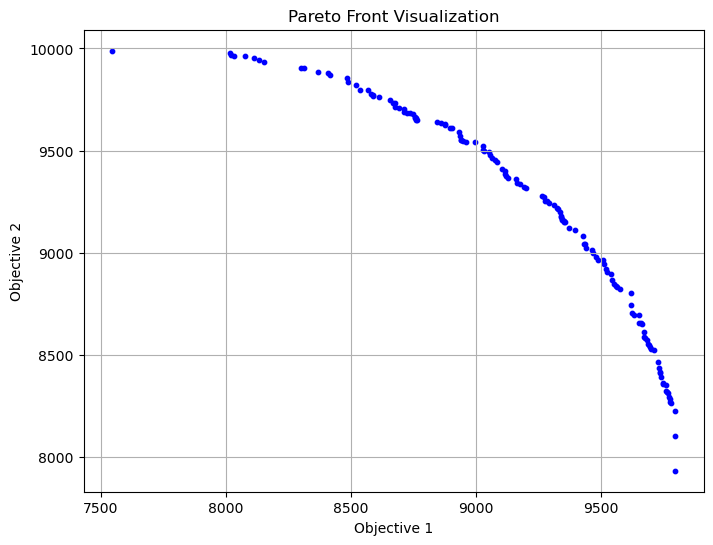

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(data[:,0], data[:,1], c='blue', s=10)
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front Visualization')
plt.grid(True)
plt.show()

In [10]:
import numpy as np
import time

# Parameters, same as C code
dimension = 2
NBITEMS = 250
FREQUANCY = 200
L = 5
paretoIni = 28000
alpha = 10
NBL = 100
kappa = 0.05
smallValue = 0.0000001

# Numpy RNG for performance
rng = np.random.default_rng(seed=1)

# Globals
nf = dimension
ni = NBITEMS
capacities = np.zeros(nf)
weights = np.zeros((nf, ni), dtype=np.int32)
profits = np.zeros((nf, ni), dtype=np.int32)
OBJ_Weights = np.zeros((nf, 10000))
vector_weight = np.zeros(nf)
nombreLIGNE = FREQUANCY // 4
nextLn = 0

def loadMOKP(filename):
    global nf, ni, capacities, weights, profits
    with open(filename, 'r') as source:
        line = source.readline()
        nf, ni = map(int, line.strip().split())
        capacities = np.zeros(nf)
        weights = np.zeros((nf, ni), dtype=np.int32)
        profits = np.zeros((nf, ni), dtype=np.int32)
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                _ = source.readline().strip()  # ignored
                weights[f, i] = int(source.readline().strip())
                profits[f, i] = int(source.readline().strip())

def read_weights_file(filename):
    global OBJ_Weights, nombreLIGNE, nf
    with open(filename, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j, i] = float(vals[j])
    nombreLIGNE = len(lines) - 1

def choose_weight():
    global vector_weight, OBJ_Weights, nextLn, nombreLIGNE, nf
    vector_weight[:] = OBJ_Weights[:,nextLn]
    nextLn = (nextLn + 1) if (nextLn < nombreLIGNE) else 0

def get_indices():
    # Calculate field indices for individual/population arrays
    # 0: nombr
    # 1: nombr_nonpris
    # 2: fitness
    # 3: explored
    # 4 ~ 4+nf: f
    # 4+nf ~ 4+2*nf: capa
    # 4+2*nf ~ 4+3*nf: v
    # d_start: 4+3*nf
    # items_start: d_start+ni
    d_start = 4 + 3 * nf
    items_start = d_start + ni
    return d_start, items_start

# Individual: (nombr, nombr_nonpris, fitness, explored, f[nf], capa[nf], v[nf], d[ni], Items[ni])
def create_pop(size):
    n_fields = 4 + 3*nf + 2*ni
    pop = np.zeros((size, n_fields))
    return pop

def init_individual(ind):
    d_start, items_start = get_indices()
    ind[d_start:d_start+ni] = np.arange(ni)
    ind[items_start:items_start+ni] = 0

def random_init_ind(pop):
    d_start, items_start = get_indices()
    size = pop.shape[0]
    for i in range(size):
        ind = pop[i]
        ind[d_start:d_start+ni] = np.arange(ni)
        rng.shuffle(ind[d_start:d_start+ni])
        ind[4:4+nf] = 0.0 # f
        ind[4+nf:4+2*nf] = 0.0 # capa
        ind[4+2*nf:4+3*nf] = 0.0 # v
        ind[items_start:items_start+ni] = 0

def evaluate_pop(pop):
    size = pop.shape[0]
    d_start, items_start = get_indices()
    for idx in range(size):
        ind = pop[idx]
        ind[0] = 0  # nombr
        ind[1] = 0  # nombr_nonpris
        ind[4:4+nf] = 0.0
        ind[4+nf:4+2*nf] = 0.0
        ind[items_start:items_start+ni] = 0
        for j in range(ni):
            l = 0
            faisable = 1
            item_idx = int(ind[d_start+j])
            while l < nf and faisable == 1:
                if ind[4+nf+l] + weights[l, item_idx] > capacities[l]:
                    faisable = 0
                l += 1
            if faisable == 1:
                for k in range(nf):
                    ind[4+nf+k] += weights[k, item_idx]
                    ind[4+k] += profits[k, item_idx]
                ind[items_start + item_idx] = 1
                ind[0] += 1
            else:
                ind[items_start + item_idx] = 0
                ind[1] += 1

def calcul_weight_pop(pop):
    size = pop.shape[0]
    for i in range(size):
        ind = pop[i]
        for j in range(nf):
            ind[4+2*nf+j] = ind[4+j] * vector_weight[j]

def calcMaxbound(pop):
    # Find max in v of all individuals
    return np.max(pop[:, 4+2*nf:4+3*nf])

def calcAddEpsIndicator(a, b, max_bound):
    # Vectorized indicator
    eps = (a[4+2*nf]/max_bound - b[4+2*nf]/max_bound)
    for i in range(1, nf):
        temp_eps = (a[4+2*nf+i]/max_bound - b[4+2*nf+i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

def update_fitness(x, I):
    x[2] -= np.exp(-I / kappa) # fitness is index 2

def update_fitness_return(f, I):
    return f - np.exp(-I / kappa)

def delete_fitness(x, I):
    x[2] += np.exp(-I / kappa)

def ind_fitness(x, pop, max_bound):
    x[2] = 0.0
    size = pop.shape[0]
    for j in range(size):
        if not np.shares_memory(x, pop[j]):
            update_fitness(x, calcAddEpsIndicator(pop[j], x, max_bound))

def compute_all_fitness(pop, max_bound):
    size = pop.shape[0]
    for i in range(size):
        ind_fitness(pop[i], pop, max_bound)

def compute_fitness_and_select(pop, x, max_bound):
    size = pop.shape[0]
    worst = -1
    ind_fitness(x, pop, max_bound)
    worst_fit = x[2]
    for i in range(size):
        fit_tmp = update_fitness_return(pop[i][2], calcAddEpsIndicator(x, pop[i], max_bound))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x[2]
    if worst == -1:
        return -1
    else:
        for i in range(size):
            delete_fitness(pop[i], calcAddEpsIndicator(pop[worst], pop[i], max_bound))
            update_fitness(pop[i], calcAddEpsIndicator(x, pop[i], max_bound))
        delete_fitness(x, calcAddEpsIndicator(pop[worst], x, max_bound))
        pop[worst] = x.copy()
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

def dominates(a, b):
    a_is_worse = False
    equal = True
    for i in range(nf):
        if a_is_worse:
            break
        if a[4+i] > b[4+i]:
            a_is_worse = True
        equal = (a[4+i] == b[4+i]) and equal
    return (not equal) and (not a_is_worse)

def non_dominated(a, b):
    a_is_good = -1
    equal = True
    for i in range(nf):
        if a[4+i] > b[4+i]:
            a_is_good = 1
        equal = (a[4+i] == b[4+i]) and equal
    if equal:
        return 0
    return a_is_good

def extractPtoArchive(P, archive):
    # Combine, then keep only non-dominated
    if archive.shape[0] == 0:
        all_pop = P.copy()
    else:
        all_pop = np.concatenate((archive, P), axis=0)
    keep = []
    for i in range(all_pop.shape[0]):
        for j in range(all_pop.shape[0]):
            if i != j:
                dom = non_dominated(all_pop[i], all_pop[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            keep.append(i)
    new_archive = all_pop[keep]
    return new_archive[:paretoIni] # keep archive size bounded

def Indicator_local_search1(SP, Sarchive, max_bound):
    d_start, items_start = get_indices()
    Sarchive = extractPtoArchive(SP, Sarchive)
    converged = False
    while not converged:
        for i in range(SP.shape[0]):
            if SP[i][3] == 0: # explored
                x = SP[i].copy()
                j = 0
                while j < int(x[0]):
                    remplace = np.zeros(L, dtype=np.int32)
                    # Remove item
                    minos = np.where(x[items_start:items_start+ni] == 1)[0]
                    if len(minos) == 0:
                        break
                    mino = rng.choice(minos)
                    x[items_start+mino] = 0
                    x[0] -= 1
                    x[1] += 1
                    for r in range(nf):
                        x[4+nf+r] -= weights[r, mino]
                        x[4+r] -= profits[r, mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        maxps = np.where(x[items_start:items_start+ni] == 0)[0]
                        if len(maxps) == 0:
                            break
                        maxp = rng.choice(maxps)
                        if maxp != mino:
                            consistant = True
                            for r in range(nf):
                                if x[4+nf+r] + weights[r,maxp] > capacities[r]:
                                    consistant = False
                                    break
                            if consistant:
                                feasible = True
                                for r in range(taille):
                                    if maxp == remplace[r]:
                                        feasible = False
                                        break
                                if feasible:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x[items_start+maxp] = 1
                                    x[1] -= 1
                                    x[0] += 1
                                    for r in range(nf):
                                        x[4+nf+r] += weights[r,maxp]
                                        x[4+r] += profits[r,maxp]
                        IM += 1
                    for tv in range(nf):
                        x[4+2*nf+tv] = x[4+tv] * vector_weight[tv]
                    sol = compute_fitness_and_select(SP, x, max_bound)
                    if sol != -1:
                        j = int(x[0]) + 1
                        if sol > i and i+1 < SP.shape[0]:
                            temp = SP[i+1].copy()
                            SP[i+1] = SP[sol]
                            SP[sol] = temp
                            i += 1
                        break
                    elif sol == -1:
                        x[items_start+mino] = 1
                        x[1] -= 1
                        x[0] += 1
                        for r in range(nf):
                            x[4+nf+r] += weights[r, mino]
                            x[4+r] += profits[r, mino]
                        if taille >= 1:
                            for r in range(taille):
                                x[items_start+remplace[r]] = 0
                                x[0] -= 1
                                x[1] += 1
                                for t in range(nf):
                                    x[4+nf+t] -= weights[t, remplace[r]]
                                    x[4+t] -= profits[t, remplace[r]]
                                    x[4+2*nf+t] = x[4+t] * vector_weight[t]
                    j += 1
                tmp_pris = int(x[0])
                if j >= tmp_pris:
                    SP[i][3] = 1 # explored
        new_archive = extractPtoArchive(SP, Sarchive)
        if new_archive.shape[0] == Sarchive.shape[0]:
            converged = True
        Sarchive = new_archive
    return Sarchive

def main():
    global nf, ni, alpha, paretoIni, FREQUANCY, L, nombreLIGNE, nextLn, vector_weight
    global capacities, weights, profits, OBJ_Weights

    loadMOKP("250.2.txt")
    read_weights_file("Weights_2obj_FQ200.txt")

    P = create_pop(0)
    init_time = 0.0
    for it in range(NBL):
        solutions = create_pop(alpha)
        archive = create_pop(0)
        for i in range(alpha):
            init_individual(solutions[i])
        random_init_ind(solutions)
        evaluate_pop(solutions)
        choose_weight()
        calcul_weight_pop(solutions)
        max_bound = calcMaxbound(solutions)
        compute_all_fitness(solutions, max_bound)
        start = time.time()
        archive = Indicator_local_search1(solutions, archive, max_bound)
        P = archive.copy()
        duration = time.time() - start
        init_time += duration
        print(f"\n {it+1} ligne DURATION {duration:.6f} time {init_time:.6f} size P {P.shape[0]}", end="")
        choose_weight()
        calcul_weight_pop(solutions)
        print()

    # Save results
    with open("2502_Results.txt", "w") as fpareto:
        for i in range(P.shape[0]):
            for j in range(nf):
                fpareto.write(f"{P[i][4+j]:.6f} ")
            fpareto.write("\n")

    print(f"{NBL} ligne DURATION {duration:.6f} time {init_time:.6f}")
    print(f"[Done] exited with code=0 in {init_time:.3f} seconds")

if __name__ == "__main__":
    main()


 1 ligne DURATION 1.839008 time 1.839008 size P 3

 2 ligne DURATION 4.803115 time 6.642123 size P 1

 3 ligne DURATION 2.903000 time 9.545123 size P 5

 4 ligne DURATION 3.629997 time 13.175120 size P 3

 5 ligne DURATION 0.546995 time 13.722115 size P 3

 6 ligne DURATION 3.453999 time 17.176114 size P 3

 7 ligne DURATION 3.319033 time 20.495147 size P 1

 8 ligne DURATION 1.635967 time 22.131114 size P 3

 9 ligne DURATION 1.057999 time 23.189113 size P 4

 10 ligne DURATION 2.399033 time 25.588146 size P 1

 11 ligne DURATION 1.750997 time 27.339143 size P 3

 12 ligne DURATION 4.536006 time 31.875149 size P 3

 13 ligne DURATION 1.421003 time 33.296153 size P 4

 14 ligne DURATION 4.783699 time 38.079852 size P 2

 15 ligne DURATION 3.985009 time 42.064861 size P 5

 16 ligne DURATION 1.537028 time 43.601890 size P 5

 17 ligne DURATION 5.914795 time 49.516685 size P 3

 18 ligne DURATION 3.786042 time 53.302727 size P 4

 19 ligne DURATION 7.540777 time 60.843504 size P 4

 20 